In [1]:
# Modified Monai 3D registration for use on multimodal imaging
%matplotlib inline
import os, sys
import glob
import random

# third party imports
import numpy as np
import scipy.io as sio
# import tensorflow.keras.backend as K
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

import SimpleITK as sitk
import io
import zipfile


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

from monai.losses import DiceLoss
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

# # Load the pretrained ResNet18 model
# pretrained_model = models.resnet18(pretrained=True)
# # print(pretrained_model)

# # Modify the first convolutional layer to accept single-channel input
# # We change the input channels to 1 (for grayscale images)
# pretrained_model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

# pretrained_model = nn.Sequential(
#     *list(pretrained_model.children())[:-2]  # This removes the final fully connected layer and average pooling layer
# )

# # pretrained_model[0][0] = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# # Move model to GPU if available
# pretrained_model = pretrained_model.cuda() if torch.cuda.is_available() else pretrained_model

/blue/eel6935/guzikjar/conda/envs/MedIm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def load_images_from_folder(folder_path, file_suffix):
    """
    Load images from a folder where filenames follow the pattern mask00XXCT.nii.gz or mask00XXMR.nii.gz.
    Args:
        folder_path: Path to the folder containing the nii.gz files.
        file_suffix: Suffix to filter the files (either 'CT.nii.gz' or 'MR.nii.gz').
        group_by_type: If True, return two separate arrays for 'MR' and 'CT' files.
    
    Returns:
        A list of SimpleITK images (or a tuple of two lists if `group_by_type=True`).
    """
    image_list = []
    
    # List all files in the directory
    files = os.listdir(folder_path)
    
    # Filter out files based on the suffix and ignore '.DS_Store'
    files = [f for f in files if f.endswith(file_suffix)]
    
    # Sort files by the numeric part in the folder name
    files.sort(key=lambda f: int(f.split('mask')[1].split(file_suffix)[0]))
    jjj = 0
    # Load images into the list
    for file_name in files:
        # print(file_name)
        file_path = os.path.join(folder_path, file_name)
        image = sitk.ReadImage(file_path)  # Load image using SimpleITK
        # image_list.append(image)
        if jjj == 0:
            voxel_spacing = image.GetSpacing()
            print('Voxel Spacing is ', voxel_spacing)
            jjj = jjj+1
        
        
        image_array = sitk.GetArrayFromImage(image)
        
        image_array = torch.from_numpy(image_array).float()
        
        image_list.append(image_array)
        
    return image_list


def extract_images(root_folder):
    """
    Extract and load images from 'L2R_Task1_CT', 'L2R_Task1_MR', and 'L2R_Task1_MRCT'.
    
    Args:
        root_folder: Path to the root folder (L2R_Task1_ROIs).
    
    Returns:
        CT_images: A list of SimpleITK images for CT files.
        MR_images: A list of SimpleITK images for MR files.
        MRCT_CT_images: A list of SimpleITK images for MRCT CT files.
        MRCT_MR_images: A list of SimpleITK images for MRCT MR files.
    """
    # Define paths
    ct_folder = os.path.join(root_folder, 'L2R_Task1_CT')
    mr_folder = os.path.join(root_folder, 'L2R_Task1_MR')
    mrct_folder = os.path.join(root_folder, 'L2R_Task1_MRCT')
    
    # Load images from the folders
    CT_images = load_images_from_folder(ct_folder, '_bcv_CT.nii.gz')
    MR_images = load_images_from_folder(mr_folder, '_chaos_MR.nii.gz')
    
    # For MRCT, group by 'CT.nii.gz' and 'MR.nii.gz'
    MRCT_CT_images = load_images_from_folder(mrct_folder, '_tcia_CT.nii.gz')
    MRCT_MR_images = load_images_from_folder(mrct_folder, '_tcia_MR.nii.gz')
    
    return CT_images, MR_images, MRCT_CT_images, MRCT_MR_images


###############################################################################################################################



def load_imgANDseg_from_folder(folder_path, prefix, suffix):
    """
    Load images starting with a specific prefix ('img' or 'seg') from a folder,
    sort them numerically, and return a list of PyTorch tensors.

    Args:
        folder_path: Path to the folder containing the nii.gz files.
        prefix: Prefix of the files to load ('img' or 'seg').

    Returns:
        A list of PyTorch tensors for the specified prefix.
    """
    image_list = []

    # List and filter files starting with the specified prefix
    files = [f for f in os.listdir(folder_path) if f.startswith(prefix) and f.endswith(suffix)]

    # Sort files based on the numeric part in their names
    files.sort(key=lambda f: int(f[len(prefix):len(prefix) + 4]))  # Extract numeric part after prefix

    # Load images and convert to PyTorch tensors
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        image = sitk.ReadImage(file_path)  # Load image using SimpleITK
        image_array = sitk.GetArrayFromImage(image)  # Convert to NumPy array
        image_tensor = torch.from_numpy(image_array).float()  # Convert to PyTorch tensor
        image_list.append(image_tensor)

    return image_list


# def extract_images_by_type(root_folder):
#     """
#     Extract and load 'img' and 'seg' files from each folder, sorted by type and order.

#     Args:
#         root_folder: Path to the root folder containing subfolders like 'L2R_Task1_CT'.

#     Returns:
#         A dictionary containing lists of PyTorch tensors for 'img' and 'seg' files from each subfolder.
#     """
#     folders = ['L2R_Task1_CT', 'L2R_Task1_MR', 'L2R_Task1_MRCT']
#     data = {}

#     for folder_name in folders:
#         folder_path = os.path.join(root_folder, folder_name)
#         img_tensors = load_images_from_folder(folder_path, 'img')
#         seg_tensors = load_images_from_folder(folder_path, 'seg')
#         data[folder_name] = {'img': img_tensors, 'seg': seg_tensors}

#     return data

In [4]:
# Functions for preprocessing and generating extra training data
def normIm(image):
    """
    Function to normalize an image to 0-255.
    
    Args:
        image: the image to be normalized; can be 2D, 3D, or 4D
        clip_min: minimum value to clip at
        clip_max: maximum value to clip at
    
    Returns:
        Image normalized to range 0-255.
    """
    
    
    # Normalize the image to the range [0, 1]
    image_min = image.min()
    image_max = image.max()

    # Perform min-max scaling to [0, 255]
    normalized_image = 255 * (image - image_min) / (image_max - image_min)

    return normalized_image

# def standard_scale_images(image_list):
#     """
#     Standard scales a list of 2D or 3D image tensors to have a mean of 0 and a standard deviation of 1.
    
#     Args:
#         image_list (list of torch.Tensor): A list of 2D or 3D tensors representing the images.
    
#     Returns:
#         list of torch.Tensor: A list of standard scaled image tensors.
#     """
#     if not all(isinstance(image, torch.Tensor) for image in image_list):
#         raise TypeError("All elements in the input list must be PyTorch tensors.")
    
#     scaled_list = []
#     for image_tensor in image_list:
#         mean = torch.mean(image_tensor)
#         std = torch.std(image_tensor)
        
#         # Prevent division by zero in case of zero standard deviation
#         if std == 0:
#             scaled_tensor = image_tensor - mean  # If std is zero, scaling makes the tensor zero-centered
#         else:
#             scaled_tensor = (image_tensor - mean) / std
        
#         scaled_list.append(scaled_tensor)
    
#     return scaled_list

def standard_scale_images(image_list, clip_min=None, clip_max=None):
    """
    Standard scales a list of 2D or 3D image tensors to have a mean of 0 and a standard deviation of 1,
    with an optional step to clip the image values before scaling.
    
    Args:
        image_list (list of torch.Tensor): A list of 2D or 3D tensors representing the images.
        clip_min (float, optional): Minimum value to clip the image tensor. Default is None.
        clip_max (float, optional): Maximum value to clip the image tensor. Default is None.
    
    Returns:
        list of torch.Tensor: A list of standard scaled image tensors.
    """
    if not all(isinstance(image, torch.Tensor) for image in image_list):
        raise TypeError("All elements in the input list must be PyTorch tensors.")
    
    scaled_list = []
    for image_tensor in image_list:
        if clip_min is not None or clip_max is not None:
            image_tensor = torch.clamp(image_tensor, min=clip_min, max=clip_max)
        
        mean = torch.mean(image_tensor)
        std = torch.std(image_tensor)
        
        # Prevent division by zero in case of zero standard deviation
        if std == 0:
            scaled_tensor = image_tensor - mean  # If std is zero, scaling makes the tensor zero-centered
        else:
            scaled_tensor = (image_tensor - mean) / std
        
        scaled_list.append(scaled_tensor)
    
    return scaled_list


def crop_images(image_list, roi_list):
    """
    Element-wise multiplies each 3D tensor in `image_list` with its corresponding
    tensor in `roi_list`.
    
    Args:
        image_list (list of torch.Tensor): A list of 3D tensors representing images.
        roi_list (list of torch.Tensor): A list of 3D tensors representing ROIs.
        
    Returns:
        list of torch.Tensor: A list of 3D tensors resulting from element-wise multiplication.
        
    Raises:
        ValueError: If the two lists have different lengths or if tensors have mismatched shapes.
    """
    if len(image_list) != len(roi_list):
        raise ValueError("The two lists must have the same number of tensors.")
    
    cropped_images = []
    
    for img, roi in zip(image_list, roi_list):
        if img.shape != roi.shape:
            raise ValueError(f"Mismatched shapes: {img.shape} and {roi.shape}")
        
        cropped_image = img * roi  # Element-wise multiplication
        cropped_images.append(cropped_image)
    
    return cropped_images



In [22]:
roi_folder = 'L2R_Task1_ROIs'  # Replace with the actual path
MR_unpaired_folder = 'L2R_Task1_MR/L2R_Task1_MR'
CT_unpaired_folder = 'L2R_Task1_CT/L2R_Task1_CT'
MRCT_paired_train_folder = 'L2R_Task1_MRCT_Train/Train'

suffixMR = 'MR.nii.gz'
suffixCT = 'CT.nii.gz'
prefix_img = 'img'
prefix_seg = 'seg'

MR_unpaired_img = load_imgANDseg_from_folder(MR_unpaired_folder, prefix_img, suffixMR)
MR_unpaired_seg = load_imgANDseg_from_folder(MR_unpaired_folder, prefix_seg, suffixMR)
CT_unpaired_img = load_imgANDseg_from_folder(CT_unpaired_folder, prefix_img, suffixCT)
CT_unpaired_seg = load_imgANDseg_from_folder(CT_unpaired_folder, prefix_seg, suffixCT)
MR_paired_img = load_imgANDseg_from_folder(MRCT_paired_train_folder, prefix_img, suffixMR)
MR_paired_seg = load_imgANDseg_from_folder(MRCT_paired_train_folder, prefix_seg, suffixMR)
CT_paired_img = load_imgANDseg_from_folder(MRCT_paired_train_folder, prefix_img, suffixCT)
CT_paired_seg = load_imgANDseg_from_folder(MRCT_paired_train_folder, prefix_seg, suffixCT)

CT_roi, MR_roi, MRCT_CT_roi, MRCT_MR_roi = extract_images(roi_folder)

MR_pre_ex = MR_unpaired_img[12]
CT_pre_ex = CT_unpaired_img[12]


MR_unpaired_img = crop_images(standard_scale_images(MR_unpaired_img, clip_min=-2, clip_max=3), MR_roi)
CT_unpaired_img = crop_images(standard_scale_images(CT_unpaired_img, clip_min=-250, clip_max=300), CT_roi)
MR_paired_img = crop_images(standard_scale_images(MR_paired_img, clip_min=-2, clip_max=3), MRCT_MR_roi)
CT_paired_img = crop_images(standard_scale_images(CT_paired_img, clip_min=-250, clip_max=300), MRCT_CT_roi)

MR_post_ex = MR_unpaired_img[12]
CT_post_ex = CT_unpaired_img[12]

MR_unpaired_seg = crop_images(MR_unpaired_seg, MR_roi)
CT_unpaired_seg = crop_images(CT_unpaired_seg, CT_roi)
MR_paired_seg = crop_images(MR_paired_seg, MRCT_MR_roi)
CT_paired_seg = crop_images(CT_paired_seg, MRCT_CT_roi)


print('Images loaded successfully...')

Voxel Spacing is  (2.0, 2.0, 2.0)
Voxel Spacing is  (2.0, 2.0, 2.0)
Voxel Spacing is  (2.0, 2.0, 2.0)
Voxel Spacing is  (2.0, 2.0, 2.0)
Images loaded successfully...


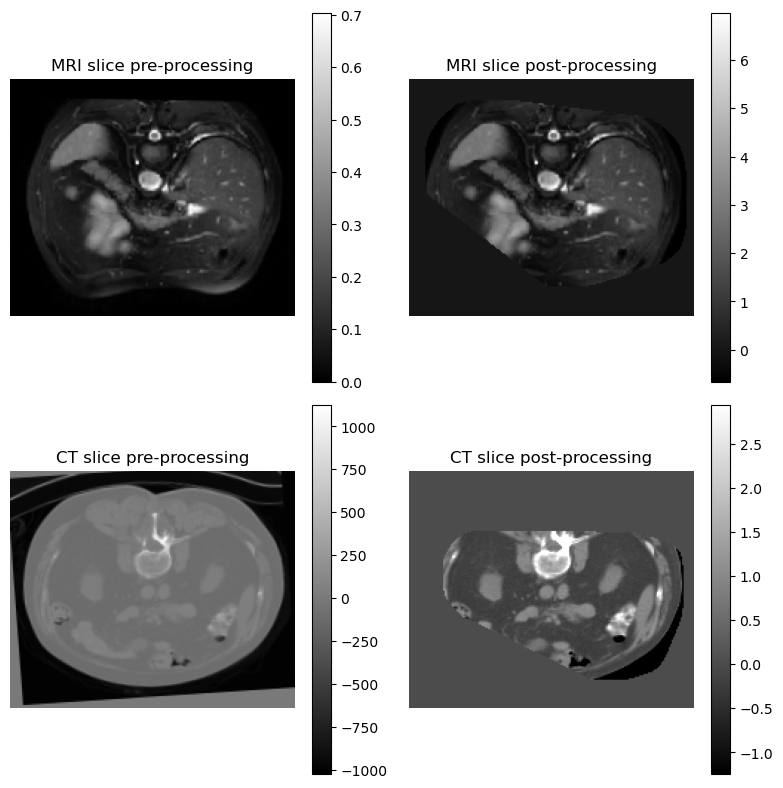

In [25]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# List of images to display
images = [MR_pre_ex[100,:,:].numpy(), MR_post_ex[100,:,:].numpy(), CT_pre_ex[100,:,:].numpy(), CT_post_ex[100,:,:].numpy()]


# Manually assign images and titles
im1 = axes[0, 0].imshow(images[0], cmap='gray')
axes[0, 0].set_title("MRI slice pre-processing")
axes[0, 0].axis('off')
fig.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(images[1], cmap='gray')
axes[0, 1].set_title("MRI slice post-processing")
axes[0, 1].axis('off')
fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 0].imshow(images[2], cmap='gray')
axes[1, 0].set_title("CT slice pre-processing")
axes[1, 0].axis('off')
fig.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(images[3], cmap='gray')
axes[1, 1].set_title("CT slice post-processing")
axes[1, 1].axis('off')
fig.colorbar(im4, ax=axes[1, 1])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [20]:
# Seperate out a validation and test set from a combination of all the images
MR_seg_test = MR_unpaired_seg[-7:]  # Last 7 images
MR_img_test = MR_unpaired_img[-7:]  # Last 7 images
CT_seg_test = CT_unpaired_seg[-7:]  # Last 7 images
CT_img_test = CT_unpaired_img[-7:]  # Last 7 images

MR_seg_val = MR_unpaired_seg[-12:-7]  # Last 5 before last 7 images
MR_img_val = MR_unpaired_img[-12:-7]  # Last 5 before last 7 images
CT_seg_val = CT_unpaired_seg[-12:-7]  # Last 5 before last 7 images
CT_img_val = CT_unpaired_img[-12:-7]  # Last 5 before last 7 images

MR_unpaired_seg_train = MR_unpaired_seg[:-12]  # All images except the last 12
MR_unpaired_img_train = MR_unpaired_img[:-12]  # All images except the last 12
CT_unpaired_seg_train = CT_unpaired_seg[:-12]  # All images except the last 12
CT_unpaired_img_train = CT_unpaired_img[:-12]  # All images except the last 12

MR_img_train = MR_paired_img + MR_unpaired_img_train
MR_seg_train = MR_paired_seg + MR_unpaired_seg_train
CT_img_train = CT_paired_img + CT_unpaired_img_train
CT_seg_train = CT_paired_seg + CT_unpaired_seg_train

In [21]:
# MR_for_paper = MR_img_train[13]
# CT_for_paper = CT_img_train[13]

# MR_for_paper_np = MR_for_paper
# # foo = MR_img_train[2]
# # print(foo.shape)

torch.Size([192, 160, 192])


torch.Size([192, 160, 192])


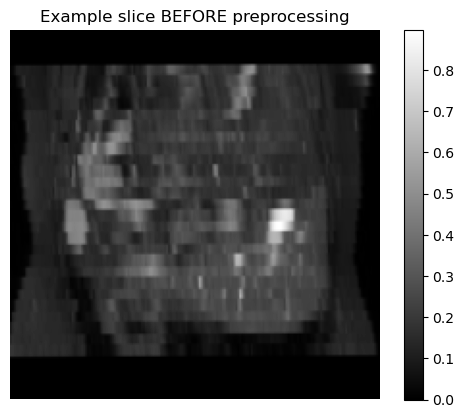

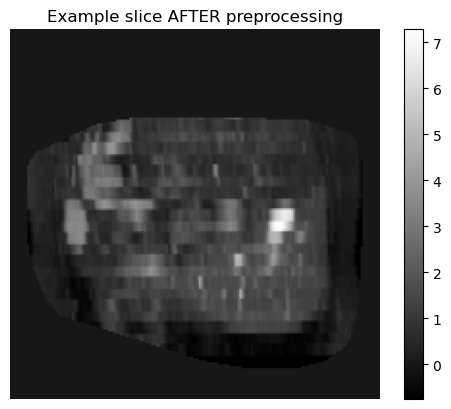

In [9]:

fig, ax = plt

plt.figure()
plt.imshow(examplepre[:,90,:], cmap='gray')
plt.title('Example slice BEFORE preprocessing')
plt.axis('off')
plt.colorbar()

plt.figure()
plt.imshow(examplepost[:,90,:], cmap='gray')
plt.title('Example slice AFTER preprocessing')
plt.axis('off')
plt.colorbar()


# 3D Affine Functions

In [7]:
# Load in batches
def volume_generator(image_list_1, image_list_2, seg_list_1, seg_list_2, mode="paired", batch_size=1):
    """
    A generator that yields all combinations of inputs exactly once per epoch.

    Args:
        image_list_1, image_list_2: Lists of 3D tensors (D x H x W).
        seg_list_1, seg_list_2: Corresponding segmentation masks for each image list.
        mode: "paired" for 1-to-1 mapping or "unpaired" for all combinations.
        batch_size: Number of samples per batch.

    Yields:
        Batches of 3D volumes and their corresponding segmentation masks.
    """
    if len(image_list_1) != len(seg_list_1) or len(image_list_2) != len(seg_list_2):
        raise ValueError("Image and segmentation lists must have the same length for each source.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Generate all combinations of indices
    if mode == "paired":
        all_combinations = [(i, i) for i in range(min(len(image_list_1), len(image_list_2)))]
    elif mode == "unpaired":
        all_combinations = [(i, j) for i in range(len(image_list_1)) for j in range(len(image_list_2))]
    else:
        raise ValueError("Mode must be 'paired' or 'unpaired'.")

    # Shuffle combinations for each epoch
    random.shuffle(all_combinations)

    # Create batches
    for start_idx in range(0, len(all_combinations), batch_size):
        I_a_batch, I_b_batch, seg_a_batch, seg_b_batch = [], [], [], []

        for idx1, idx2 in all_combinations[start_idx:start_idx + batch_size]:
            # turn segmentation maps into one-hot-encoding
            seg_a = torch.nn.functional.one_hot(seg_list_1[idx1].long(), num_classes=5)
            seg_a = seg_a.permute(3,0,1,2)
            seg_b = torch.nn.functional.one_hot(seg_list_2[idx2].long(), num_classes=5)
            seg_b = seg_b.permute(3,0,1,2)
            
            I_a_batch.append(image_list_1[idx1].unsqueeze(0))  # Add channel dimension
            I_b_batch.append(image_list_2[idx2].unsqueeze(0))  # Add channel dimension
            # seg_a_batch.append(seg_list_1[idx1].unsqueeze(0))
            # seg_b_batch.append(seg_list_2[idx1].unsqueeze(0))
            
            
            seg_a_batch.append(seg_a)  
            seg_b_batch.append(seg_b)  

        
        
        # Stack the batches into tensors
        I_a_batch = torch.stack(I_a_batch, dim=0).to(device)
        I_b_batch = torch.stack(I_b_batch, dim=0).to(device)
        seg_a_batch = torch.stack(seg_a_batch, dim=0).to(device)
        seg_b_batch = torch.stack(seg_b_batch, dim=0).to(device)
        

        yield I_a_batch, I_b_batch, seg_a_batch, seg_b_batch
        

def single_volume_generator(image_list, seg_list, batch_size=1, num_classes=5):
    """
    A generator that yields batches of 3D volumes and their corresponding one-hot encoded segmentation masks.

    Args:
        image_list: List of 3D tensors (D x H x W) representing the images.
        seg_list: Corresponding segmentation masks for each image list (not one-hot encoded).
        batch_size: Number of samples per batch.
        num_classes: Number of classes for one-hot encoding the segmentation masks.

    Yields:
        Batches of 3D volumes and their corresponding one-hot encoded segmentation masks.
    """
    if len(image_list) != len(seg_list):
        raise ValueError("Image list and segmentation list must have the same length.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Shuffle the data indices for each epoch
    indices = list(range(len(image_list)))
    random.shuffle(indices)

    # Create batches
    for start_idx in range(0, len(indices), batch_size):
        I_batch, seg_batch = [], []

        for idx in indices[start_idx:start_idx + batch_size]:
            # Add channel dimension to images
            I_batch.append(image_list[idx].unsqueeze(0))  # Add channel dimension

            # One-hot encode segmentation masks
            seg_one_hot = torch.nn.functional.one_hot(seg_list[idx].long(), num_classes=num_classes)
            seg_one_hot = seg_one_hot.permute(3, 0, 1, 2)  # Change to [C, D, H, W]
            seg_batch.append(seg_one_hot)

        # Stack the batches into tensors
        I_batch = torch.stack(I_batch, dim=0).to(device)
        seg_batch = torch.stack(seg_batch, dim=0).to(device)

        yield I_batch, seg_batch        

class IndexedGenerator:
    def __init__(self, generator_function, seed=None):
        """
        Wrap a generator function to allow indexed access to its yields, ensuring reproducibility.
        
        Args:
            generator_function (callable): A generator function.
            seed (int, optional): Random seed for deterministic behavior.
        """
        self.generator_function = generator_function
        self.seed = seed
        self.cache = []  # Cache to store results
        self.index = 0   # Tracks the current index in the generator

    def reset_generator(self):
        """
        Reset the generator with the same seed for reproducibility.
        """
        if self.seed is not None:
            random.seed(self.seed)
        self.generator = self.generator_function()

    def __getitem__(self, idx):
        """
        Get the nth yield from the generator, caching results for reuse.
        
        Args:
            idx (int): The index of the yield to retrieve.
        
        Returns:
            The generated item at the specified index.
        """
        if idx < 0:
            raise ValueError("Index must be non-negative.")
        
        # Reset the generator if it hasn't been initialized
        if not hasattr(self, "generator"):
            self.reset_generator()

        # Generate and cache values up to the requested index
        while len(self.cache) <= idx:
            try:
                self.cache.append(next(self.generator))
            except StopIteration:
                raise IndexError("Generator has been exhausted.")
        
        return self.cache[idx]

    def next(self):
        """
        Get the next item from the generator, advancing the current index.
        
        Returns:
            The next item from the generator.
        """
        value = self[self.index]
        self.index += 1
        return value

    def reset(self):
        """
        Reset the generator and clear the cache.
        """
        self.cache.clear()
        self.index = 0
        self.reset_generator()

        
def deterministic_gen():
    return deterministic_volume_generator(
        list_1, list_2, seg_list_1, seg_list_2, mode="paired", batch_size=2, deterministic=True
    )

In [8]:
######################################### Create Feature Extractors ####################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CT_SWIN = SwinUNETR(
    img_size=(192, 160, 192),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

# uncomment to download the pre-trained weights
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt
weight = torch.load("./model_swinvit.pt")

CT_SWIN.load_from(weights=weight)


MR_SWIN = SwinUNETR(
    img_size=(192, 160, 192),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

# weight_MR = torch.load("./swin_unet_MRI.pt")
# MR_SWIN.load_from(weights=weight)
MR_SWIN = torch.load("swin_unet_MRI_model.pt")
MR_SWIN.to(device)



/blue/eel6935/guzikjar/conda/envs/MedIm/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
/scratch/local/52682854/ipykernel_610776/1608472466.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_feature

In [69]:
# num_epochs = 30


# # Training parameters
# num_epochs = 30
# batch_size = 1
# num_classes = 5

# # Define device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# loss_swin = torch.nn.CrossEntropyLoss()  # Use CrossEntropyLoss for logits and one-hot segmentation
# optimizer = optim.Adam(MR_SWIN.parameters(), lr=1e-4)


# # Training loop
# for epoch in range(num_epochs):
#     MR_SWIN.train()
#     epoch_loss = 0

#     # Initialize data generator
#     generator = single_volume_generator(MR_img_train, MR_seg_train, batch_size=1, num_classes=5)

#     for I_batch, seg_batch in generator:
#         # Move data to device
#         I_batch = I_batch.to(device)         # [B, 1, D, H, W]
#         seg_batch = seg_batch.to(device)     # [B, C, D, H, W]

#         # Forward pass
#         output_logits = MR_SWIN(I_batch)     # Output shape: [B, C, D, H, W]

#         # Compute loss
#         # Convert one-hot encoded segmentation to class indices for CrossEntropyLoss
#         seg_target = torch.argmax(seg_batch, dim=1)  # Shape: [B, D, H, W]
#         loss = loss_swin(output_logits, seg_target)

#         # Backpropagation and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     # Print epoch loss
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# # Save the trained model
# torch.save(MR_SWIN, "swin_unet_MRI_model.pt")




Epoch [1/30], Loss: 71.3059
Epoch [2/30], Loss: 47.2946
Epoch [3/30], Loss: 37.2659
Epoch [4/30], Loss: 30.6692
Epoch [5/30], Loss: 25.7314
Epoch [6/30], Loss: 21.7503
Epoch [7/30], Loss: 18.7347
Epoch [8/30], Loss: 16.1121
Epoch [9/30], Loss: 14.0870
Epoch [10/30], Loss: 12.5277
Epoch [11/30], Loss: 11.0996
Epoch [12/30], Loss: 10.0546
Epoch [13/30], Loss: 8.8052
Epoch [14/30], Loss: 7.8734
Epoch [15/30], Loss: 7.1198
Epoch [16/30], Loss: 6.4204
Epoch [17/30], Loss: 5.7569
Epoch [18/30], Loss: 5.3072
Epoch [19/30], Loss: 4.8617
Epoch [20/30], Loss: 4.4278
Epoch [21/30], Loss: 4.0233
Epoch [22/30], Loss: 3.8006
Epoch [23/30], Loss: 3.4617
Epoch [24/30], Loss: 3.2080
Epoch [25/30], Loss: 2.9763
Epoch [26/30], Loss: 2.7826
Epoch [27/30], Loss: 2.6327
Epoch [28/30], Loss: 2.4369
Epoch [29/30], Loss: 2.2836
Epoch [30/30], Loss: 2.1533


In [34]:
# print(dir(CT_SWIN))

In [34]:
#################################### 3D Feature Extraction ############################################

class ResNet3DFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, output_channels=64):
        super(ResNet3DFeatureExtractor, self).__init__()
        # Initial Conv Layer
        self.conv1 = nn.Conv3d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        # Residual Block 1
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        
        # Residual Block 2
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        
        # Residual Block 3
        self.layer3 = self._make_layer(128, output_channels, num_blocks=2, stride=2)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(self._make_residual_block(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(self._make_residual_block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def _make_residual_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_channels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

    
class SwinUNETREncoder(nn.Module):
    def __init__(self, pretrained_model=CT_SWIN, freeze_weights=True):
        super(SwinUNETREncoder, self).__init__()
        # Use the encoder part of SwinUNETR
        self.encoder = pretrained_model.swinViT
        if freeze_weights:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        # Forward through the encoder to get feature maps
        return self.encoder(x)
    
class SwinMRIEncoder(nn.Module):
    def __init__(self, pretrained_model=MR_SWIN, freeze_weights=True):
        super(SwinUNETREncoder, self).__init__()
        # Use the encoder part of SwinUNETR
        self.encoder = pretrained_model.swinViT
        if freeze_weights:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        # Forward through the encoder to get feature maps
        return self.encoder(x)
    
###################################################################################################################

################################### 3D Correlation ###############################################################

class CorrelationLayer3D(nn.Module):
    def __init__(self, num_features=384):
        """
        Initialize the CorrelationLayer with batch normalization for 3D feature maps.
        
        Args:
            num_features (int): The number of features in the feature maps (default is 1024).
        """
        super(CorrelationLayer3D, self).__init__()
        
        # Batch normalization layer for the feature maps
        self.batch_norm = nn.BatchNorm3d(num_features)

    def forward(self, features_a, features_b):
        """
        Perform the forward pass: Apply ReLU, batch normalization, and compute the correlation matrix.
        
        Args:
            features_a (Tensor): Feature map from image A, shape [B, C, D, H, W].
            features_b (Tensor): Feature map from image B, shape [B, C, D, H, W].
            
        Returns:
            Tensor: The correlation matrix, shape [B, D*H*W, D*H*W].
        """
        
#         # Apply batch normalization to both feature maps
#         features_a = self.batch_norm(features_a)
#         features_b = self.batch_norm(features_b)
        
#         # Apply ReLU activation to both feature maps
#         features_a = F.relu(features_a)
#         features_b = F.relu(features_b)
        
       
        # Get batch size, number of channels (features), depth, height, and width
        B, C, D, H, W = features_a.shape
        
        # Reshape the feature maps to (B, C, D*H*W)
        features_a_reshaped = features_a.view(B, C, -1)  # Shape: [B, C, D*H*W]
        features_b_reshaped = features_b.view(B, C, -1)  # Shape: [B, C, D*H*W]
        
        # Compute the pairwise correlations via matrix multiplication
        # features_a_reshaped and features_b_reshaped both have shape [B, C, D*H*W]
        # Transpose features_b_reshaped to align the features for the dot product
        correlation_matrix = torch.matmul(features_a_reshaped.transpose(1, 2), features_b_reshaped)  # Shape: [B, D*H*W, D*H*W]
        
        correlation_matrix = correlation_matrix.view(B, H*W*D, D, H, W)
                
        correlation_matrix = F.relu(correlation_matrix)
        
        # Compute the L2 norm along dimension 1 (channel dimension)
        # Keep dimension to broadcast correctly
        l2_norm = torch.norm(correlation_matrix, p=2, dim=1, keepdim=True)  # Shape: [1, 1, 12, 10, 12]

        # Normalize by dividing the tensor by its L2 norm
        correlation_normalized = correlation_matrix / (l2_norm + 1e-8)  # Add a small epsilon to avoid division by zero

        
        return correlation_normalized
    
################################################################################################################################


########################### Affine Regression Network ##########################################################################

class RegressionNetwork3D(nn.Module):
    def __init__(self, input_channels=1440, num_outputs=12):
        """
        Initialize the Regression Network for 3D affine transformation prediction.
        
        Args:
            input_channels (int): The number of input channels (default is 1440).
            num_outputs (int): The number of output values (default is 12, for affine parameters).
        """
        super(RegressionNetwork3D, self).__init__()
        
        # First 3D convolutional layer
        self.conv1 = nn.Conv3d(
            in_channels=input_channels, 
            out_channels=512, 
            kernel_size=7, 
            stride=1, 
            padding=3  # To maintain same size
        )
        self.bn1 = nn.BatchNorm3d(512)  # Batch normalization for the first conv layer
        
        # First 3D convolutional layer
        self.conv2 = nn.Conv3d(
            in_channels=512, 
            out_channels=128, 
            kernel_size=7, 
            stride=1, 
            padding=3  # To maintain same size
        )
        self.bn2 = nn.BatchNorm3d(128)  # Batch normalization for the first conv layer
        
        # Second 3D convolutional layer
        self.conv3 = nn.Conv3d(
            in_channels=128, 
            out_channels=64, 
            kernel_size=5, 
            stride=1, 
            padding=2  # To maintain same size
        )
        self.bn3 = nn.BatchNorm3d(64)  # Batch normalization for the second conv layer
        
        # Fully connected layer
        # The input dimensions of the fully connected layer are determined by the final spatial size
        self.fc = nn.Linear(64 * 12 * 10 * 12, num_outputs)  # Adjust based on spatial size after conv2

    def forward(self, x):
        """
        Perform the forward pass through the network.
        
        Args:
            x (Tensor): Input tensor of shape [B, C, D, H, W].
            
        Returns:
            Tensor: Output tensor of shape [B, num_outputs].
        """
        # First conv layer
        x = self.conv1(x)  # Shape: [B, 512, D, H, W]
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second conv layer
        x = self.conv2(x)  # Shape: [B, 256, D, H, W]
        x = self.bn2(x)
        x = F.relu(x)
        
        # Third conv layer
        x = self.conv3(x)  # Shape: [B, 64, D, H, W] (assuming padding maintains the spatial size)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Flatten for the fully connected layer
        x = torch.flatten(x, start_dim=1)  # Shape: [B, 64 * D * H * W]
        
        # Fully connected layer
        x = self.fc(x)  # Shape: [B, num_outputs]
        
        # print(x)
        
        return x
    
    
######################################################################################################################


############################## Perform affine transformation #########################################################

class AffineTransformation3D(nn.Module):
    def __init__(self, image_shape, device='cuda'):
        """
        Differentiable 3D affine transformation module.

        Args:
            image_shape (tuple): The shape of the 3D image (D, H, W).
        """
        super(AffineTransformation3D, self).__init__()
        self.image_shape = image_shape  # Store the shape of the image for normalization
        self.device = device
        self.ident = torch.tensor([ [1, 0, 0, 0, 
                                0, 1, 0, 0,
                                0, 0, 1, 0] ], device=self.device)
        self.alpha = 0.1
    
    def forward(self, moving_image, moving_seg, theta):
        """
        Apply the affine transformation to the moving image and segmentation map using differentiable grid sampling.

        Args:
            moving_image (torch.Tensor): Moving image of shape [B, 1, D, H, W].
            moving_seg (torch.Tensor): Moving segmentation map of shape [B, 1, D, H, W].
            theta (torch.Tensor): Affine transformation parameters of shape [B, 12].

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Transformed image and segmentation map.
        """
        
        
        
        
        # scale theta and add to identity matrix
        # theta = theta*self.alpha + self.ident
        theta1 = theta*self.alpha + self.ident
        
        
        # Ensure theta is reshaped into a proper affine matrix (B, 3, 4)
        theta1 = theta1.view(-1, 3, 4)  # Convert from 12-vector to 3x4 affine matrices
        
        # TODO: Change to have voxel spacing be a class definition
        
        image_physical_shape = torch.tensor([self.image_shape[0],
                                            self.image_shape[1],
                                            self.image_shape[2]], 
                                            dtype=torch.float)
        
        # Normalize translation using voxel_spacing and image physical extents
        scaling_factors = image_physical_shape / 2
        theta1[:, 0, 3] /= scaling_factors[0]
        theta1[:, 1, 3] /= scaling_factors[1]
        theta1[:, 2, 3] /= scaling_factors[2]
        
        # print(theta.requires_grad)
      
        
        # Create a sampling grid based on affine transformation
        grid = F.affine_grid(theta1, moving_image.size(), align_corners=False)  # Generates a 3D sampling grid
        # print(grid.shape)
        # print(grid.requires_grad)

        # Perform sampling on the image with linear interpolation
        transformed_img = F.grid_sample(moving_image, grid, mode='bilinear', padding_mode='border', align_corners=False)
        
        # Perform sampling on the segmentation map with nearest neighbor interpolation
        
        transformed_seg = F.grid_sample(moving_seg.float(), grid, mode='nearest', padding_mode='border', align_corners=False)
        # print(f'transformed_Seg:{transformed_seg.requires_grad}')
        

        return transformed_img, transformed_seg
    
###############################################################################################################################




############################################### Dice Loss #####################################################################
# class DiceLoss3D(nn.Module):
#     def __init__(self, smooth=1e-6):
#         """
#         Initialize the Dice Loss for 3D segmentation tasks.
        
#         Args:
#             smooth (float): Smoothing factor to avoid division by zero. Default is 1e-6.
#         """
#         super(DiceLoss3D, self).__init__()
#         self.smooth = smooth

#     def forward(self, pred, target):
#         """
#         Compute the Dice loss for 3D segmentation tasks.
        
#         Args:
#             input (Tensor): The predicted segmentation map of shape [B, C, D, H, W], where B is the batch size, 
#                              C is the number of classes, and D, H, W are the spatial dimensions.
#             target (Tensor): The ground truth segmentation map of the same shape as input.
        
#         Returns:
#             Tensor: The computed Dice loss.
#         """
#         # Flatten the tensor into a 2D shape (B x (D*H*W)) for easy calculation of intersections
#         pred = pred.view(pred.size(0), -1)
#         target = target.view(target.size(0), -1)

#         # Convert to long type for class comparison
#         pred = pred.long()
#         target = target.long()

#         # Flatten the predictions and ground truth for each class (except the background class)
#         dice_loss = 0.0
#         num_classes = len(torch.unique(target))  # Number of classes (C)
        
#         for class_id in range(num_classes-1):
#             # Create binary masks for each class
#             pred_class = (pred == class_id+1).float()
#             target_class = (target == class_id+1).float()

#             # Compute intersection and union
#             intersection = torch.sum(pred_class * target_class)
#             union = torch.sum(pred_class) + torch.sum(target_class)

#             # Compute Dice score for this class
#             dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
#             dice_loss += 1 - dice_score

#         # Average the Dice scores across all classes
#         avg_dice_loss = dice_loss / (num_classes - 1)
#         return avg_dice_loss
    

    
# class MultiClassDiceLoss(nn.Module):
#     def __init__(self, smooth=1e-6):
#         """
#         Computes a multi-class Dice loss between two segmentation maps.

#         Args:
#             smooth (float): Smoothing constant to avoid division by zero.
#         """
#         super(MultiClassDiceLoss, self).__init__()
#         self.smooth = smooth

#     def forward(self, predictions, targets):
#         """
#         Forward pass to compute Dice loss.

#         Args:
#             predictions (Tensor): Predicted segmentation map (shape: [B, 1, D, H, W]).
#             targets (Tensor): Ground truth segmentation map (shape: [B, 1, D, H, W]).

#         Returns:
#             Tensor: Dice loss value.
#         """
#         # Ensure predictions and targets are integers
#         predictions = predictions.long()
#         targets = targets.long()

#         # Convert predictions and targets into one-hot encoding
#         num_classes = 5  # Assuming the segmentation map has 5 classes
#         preds_one_hot = torch.nn.functional.one_hot(predictions.squeeze(1), num_classes=num_classes)  # Shape: [B, D, H, W, num_classes]
#         targets_one_hot = torch.nn.functional.one_hot(targets.squeeze(1), num_classes=num_classes)  # Shape: [B, D, H, W, num_classes]

#         # Rearrange dimensions to match multi-class computation
#         preds_one_hot = preds_one_hot.permute(0, 4, 1, 2, 3).float()  # Shape: [B, num_classes, D, H, W]
#         targets_one_hot = targets_one_hot.permute(0, 4, 1, 2, 3).float()  # Shape: [B, num_classes, D, H, W]

#         # Clip predictions to ensure numerical stability
#         predictions = torch.clamp(preds_one_hot, min=1e-7, max=1.0)

#         # Compute intersection and union across all voxels
#         intersection = torch.sum(predictions * targets_one_hot, dim=(2, 3, 4))  # Shape: [B, num_classes]
#         union = torch.sum(predictions, dim=(2, 3, 4)) + torch.sum(targets_one_hot, dim=(2, 3, 4))  # Shape: [B, num_classes]

#         # Compute per-class Dice scores
#         dice_score = (2 * intersection + self.smooth) / (union + self.smooth)  # Shape: [B, num_classes]

#         # Compute average Dice loss across classes and batches
#         dice_loss = 1 - dice_score.mean()

#         return dice_loss

class VoxelDice:
    """
    N-D dice for segmentation
    """

    def loss(self, y_true, y_pred):
        ndims = len(list(y_pred.size())) - 2
        vol_axes = list(range(2, ndims + 2))
        top = 2 * (y_true * y_pred).sum(dim=vol_axes)
        bottom = torch.clamp((y_true + y_pred).sum(dim=vol_axes), min=1e-5)
        dice = torch.mean(top / bottom)
        return -dice
    
    
###################################################################################################################


############################### Full Affine Network ###############################################################

class FullAffineModel(nn.Module):
    def __init__(self, image_shape):
        super(FullAffineModel, self).__init__()
        
        # Initialize each component of the model
        # self.ResNet3DFeatureExtractor = ResNet3DFeatureExtractor(input_channels=1, output_channels=64)  # Assuming it returns I_a_features, I_b_features
        self.SwinUNETREncoder = SwinUNETREncoder() # Not trainable
        self.SwinMRIEncoder = SwinMRIEncoder() # Not trainable
        # self.pool = torch.nn.Conv3d(in_channels=768, out_channels=86, kernel_size=1, stride=1)
        self.CorrelationLayer3D = CorrelationLayer3D()  # Computes pairwise correlations
        self.RegressionNetwork3D = RegressionNetwork3D()  # Computes affine transformation parameters
        self.AffineTransformation3D = AffineTransformation3D(image_shape)  # Applies affine transformation
    
    def forward(self, I_a, I_b, seg_a, seg_b):
        # Forward pass: Extract features from both images
        I_a_features = self.SwinUNETREncoder(I_a)[-2] # Use for unimodal CT
        # I_a_features = self.SwinMRIEncoder(I_b)[-2] # Use for multimodal
        I_b_features = self.SwinUNETREncoder(I_b)[-2]
        
                
        # Apply the correlation layer
        correlation_output = self.CorrelationLayer3D(I_a_features, I_b_features)
        # print(f"correlation_output requires grad: {correlation_output.requires_grad}")
        # print(correlation_output.shape)
        
        # Predict affine transformation parameters
        affine_theta = self.RegressionNetwork3D(correlation_output)
        # print(f"affine_theta requires grad: {affine_theta.requires_grad}")
                
        # Apply affine transformation to the moving image and its segmentation
        transformed_img_b, transformed_seg_b = self.AffineTransformation3D(I_b, seg_b, affine_theta)
        
        # print("Tensor Grad Status in Forward Pass:")
        # print(f"I_a_features requires_grad: {I_a_features.requires_grad}")
        # print(f"I_b_features requires_grad: {I_b_features.requires_grad}")
        # print(f"correlation_output requires_grad: {correlation_output.requires_grad}")
        # print(f"affine_theta requires_grad: {affine_theta.requires_grad}")
        # print(f"transformed_seg_b requires_grad: {transformed_seg_b.requires_grad}")

        
        return transformed_seg_b, transformed_img_b, affine_theta



In [33]:
###################### Perform some testing ##########################

testModel = FullAffineModel(image_shape=(192,160,192))
testGen = volume_generator(MR_img_train, MR_img_train, MR_seg_train, MR_seg_train, mode="unpaired", batch_size=1)
I_a_batch, I_b_batch, seg_a_batch, seg_b_batch = next(testGen)
testModel.to(device)
# testGen.to(device)

I_a_batch.to(device)
I_b_batch.to(device)
seg_a_batch.to(device)
seg_b_batch.to(device)

transformed_seg_b, transformed_img_b, affine_theta = testModel(I_a_batch, I_b_batch, seg_a_batch, seg_b_batch)


# test_generator = volume_generator(MR_paired_img, CT_paired_img, MR_paired_seg, CT_paired_seg, mode="paired", batch_size=1)

# I_a_batch, I_b_batch, seg_a_batch, seg_b_batch = next(test_generator)

# model = FullAffineModel(image_shape=(192, 160, 192))

# # test with no training
# tran_bar2, tran_foo2, aff_theta = model(foo, foo2, bar, bar2)




torch.Size([1, 1440, 12, 10, 12])


In [61]:
# model = FullAffineModel(image_shape=(192, 160, 192))

# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

Text(0.5, 1.0, 'Moved Ib image')

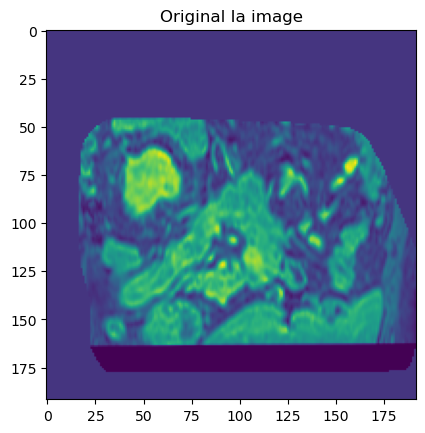

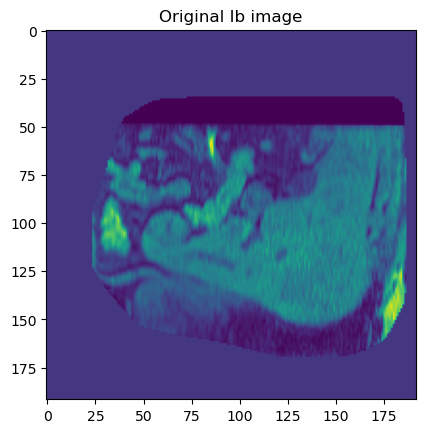

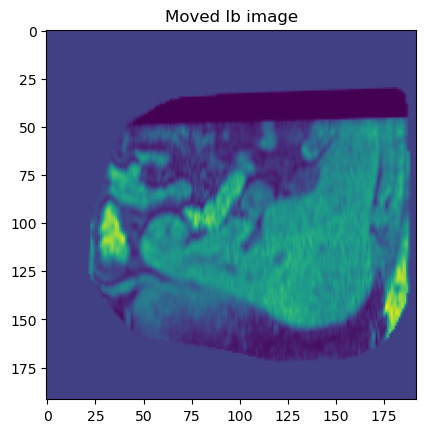

In [46]:
foo = foo.squeeze()
foo2 = foo2.squeeze()
moved_foo2 = tran_foo2.detach().cpu().numpy()
moved_foo2 = moved_foo2.squeeze()

plt.figure()
plt.imshow(foo[:,90,:])
plt.title('Original Ia image')

plt.figure()
plt.imshow(foo2[:,90,:])
plt.title('Original Ib image')

plt.figure()
plt.imshow(moved_foo2[:,90,:])
plt.title('Moved Ib image')

Text(0.5, 1.0, 'Moved Ib segmentation')

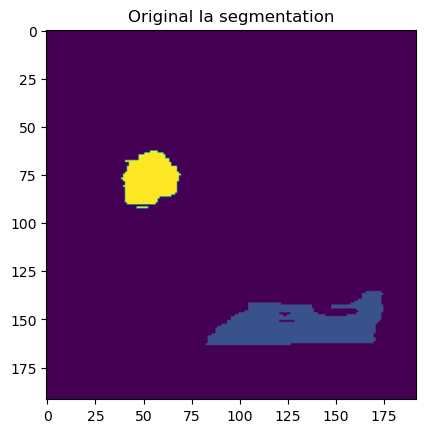

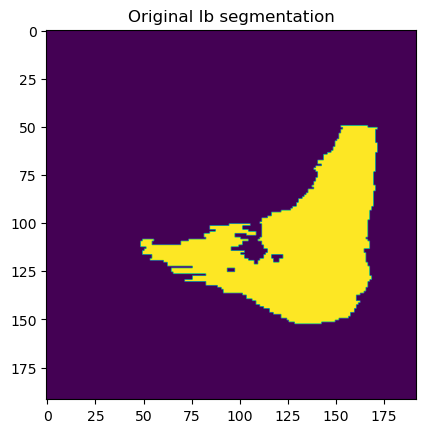

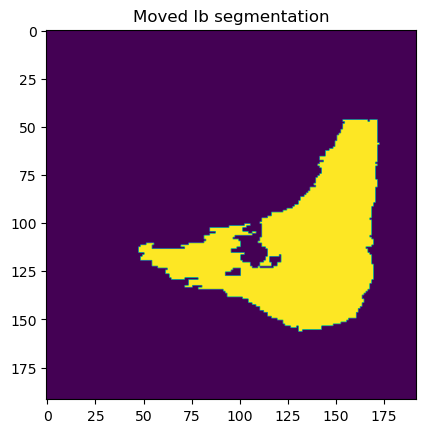

In [48]:
bar = bar.squeeze()
bar2 = bar2.squeeze()
moved_bar2 = tran_bar2.detach().cpu().numpy()
moved_bar2 = moved_bar2.squeeze()

plt.figure()
plt.imshow(bar[:,90,:])
plt.title('Original Ia segmentation')

plt.figure()
plt.imshow(bar2[:,90,:])
plt.title('Original Ib segmentation')

plt.figure()
plt.imshow(moved_bar2[:,90,:])
plt.title('Moved Ib segmentation')

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear the cache
torch.cuda.empty_cache()

# Reset the default CUDA allocator
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

# Optionally call garbage collection
import gc
gc.collect()


# Training loop
# def train(model, generator, num_epochs, device):
#     # Assuming the model has been initialized as the final affine transformer
#     # Define the optimizer
#     optimizer = optim.Adam(model.parameters(), lr=1e-4)

#     # Initialize the DiceLoss3D
#     dice_loss_fn = DiceLoss(include_background=False, softmax=False, to_onehot_y=True, reduction="mean")
    
#     model.to(device)
#     # dice_loss_fn.to(device)

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
        
#         for batch_idx, (I_a_batch, I_b_batch, seg_a_batch, seg_b_batch) in enumerate(generator):
#             # Move batches to device
#             I_a_batch = I_a_batch.to(device)
#             I_b_batch = I_b_batch.to(device)
#             seg_a_batch = seg_a_batch.to(device)
#             seg_b_batch = seg_b_batch.to(device)
            
#             # Zero the gradients
#             optimizer.zero_grad()
            

#             transformed_seg_b, transformed_img_b, affine_theta = model(I_a_batch, I_b_batch, seg_a_batch, seg_b_batch)

# #             # Step 1: Feature extraction using ResNet3DFeatureExtractor
# #             I_a_features = model.ResNet3DFeatureExtractor(I_a_batch)
# #             I_b_features = model.ResNet3DFeatureExtractor(I_b_batch)

# #             # Step 2: Apply CorrelationLayer3D
# #             correlation_output = model.CorrelationLayer3D(I_a_features, I_b_features)

# #             # Step 3: Get affine transformation parameters using RegressionNetwork3D
# #             affine_theta = model.RegressionNetwork3D(correlation_output)

# #             # Step 4: Apply the affine transformation using AffineTransformation3D
# #             _ , transformed_seg_b = model.AffineTransformation3D(I_b_batch, seg_b_batch, affine_theta)
           
            
#             test_seg_pred = torch.nn.functional.one_hot(transformed_seg_b.squeeze(1).long())
#             test_seg_pred = test_seg_pred.permute(0,4,1,2,3)
           

#             # Step 5: Compute the Dice loss
#             dice_loss = dice_loss_fn(transformed_seg_b, seg_a_batch)
            
#             # print("Transformed segmentation map requires grad:", transformed_seg_b.requires_grad)  # Should be True
#             # print("Ground truth segmentation map requires grad:", seg_a_batch.requires_grad)      # Typically False (expected for targets)
#             # print("Loss tensor requires grad:", dice_loss.requires_grad)
            
#             torch.autograd.set_detect_anomaly(True)
            
#             # Step 6: Backpropagation and optimization
#             dice_loss.backward()
#             optimizer.step()
            
#             running_loss += dice_loss.item()
            
#             # Print running loss every so often (you can customize the frequency)
#             if batch_idx % 10 == 0:
#                 print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}], Dice Loss: {dice_loss.item():.4f}")

#         # Print the average loss for the epoch
#         print(f"Epoch [{epoch+1}/{num_epochs}] finished. Average Dice Loss: {running_loss / num_epochs:.4f}")

def train(model, image_list_1, image_list_2, seg_list_1, seg_list_2, num_epochs, batch_size, device, mode="unpaired"):
    """
    Training loop for the 3D registration network.

    Args:
        model: The registration network.
        image_list_1, image_list_2: Lists of 3D images.
        seg_list_1, seg_list_2: Corresponding segmentation maps.
        num_epochs: Number of epochs to train.
        batch_size: Batch size.
        device: Device to run the model on.
        mode: "paired" or "unpaired" mode for data generation.
    """
    # Initialize the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # dice_loss_fn = DiceLoss(include_background=False, softmax=False, to_onehot_y=False, reduction="mean") # Monai Dice Loss
    # dice_loss_fn = VoxelDice() # Voxelmorph Dice Loss
    dice_loss_fn = torch.nn.MSELoss() # MSE Loss

    model.to(device)
    
    # print("Optimizer Parameters:")
    # for param_group in optimizer.param_groups:
    #     for param in param_group['params']:
    #         print(param.shape, param.requires_grad)



    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Create generator for the current epoch
        generator = volume_generator(image_list_1, image_list_2, seg_list_1, seg_list_2, mode=mode, batch_size=batch_size)

        print(f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (I_a_batch, I_b_batch, seg_a_batch, seg_b_batch) in enumerate(generator):
            optimizer.zero_grad()
            

            # Forward pass
            # transformed_seg_b, affine_theta = model(I_a_batch, I_b_batch, seg_a_batch, seg_b_batch)
            transformed_seg_b, transformed_img_b, affine_theta = model(I_a_batch, I_b_batch, seg_a_batch, seg_b_batch)
            
                       
            # fixed_seg_a = torch.nn.functional.one_hot(seg_a_batch.squeeze(1).long(), num_classes=5)
            # fixed_seg_a = fixed_seg_a.permute(0,4,1,2,3)
            # fixed_seg_a = seg_a_batch
            # print(transformed_seg_b.shape)
            
#             Ia_seg1 = seg_a_batch[:,1,:,:,:]
#             Ia_seg2 = seg_a_batch[:,2,:,:,:]
#             Ia_seg3 = seg_a_batch[:,3,:,:,:]
#             Ia_seg4 = seg_a_batch[:,4,:,:,:]
            
#             Ib_seg1 = transformed_seg_b[:,1,:,:,:]
#             Ib_seg2 = transformed_seg_b[:,2,:,:,:]
#             Ib_seg3 = transformed_seg_b[:,3,:,:,:]
#             Ib_seg4 = transformed_seg_b[:,4,:,:,:]

            # Compute Dice loss
            # dice_loss = ( dice_loss_fn(Ib_seg1, Ia_seg1) + dice_loss_fn(Ib_seg2, Ia_seg2) + 
            #              dice_loss_fn(Ib_seg3, Ia_seg3) + dice_loss_fn(Ib_seg4, Ia_seg4) )/4 # Monai
            # dice_loss = ( dice_loss_fn.loss(Ib_seg1, Ia_seg1) + dice_loss_fn.loss(Ib_seg2, Ia_seg2) + 
            #              dice_loss_fn.loss(Ib_seg3, Ia_seg3) + dice_loss_fn.loss(Ib_seg4, Ia_seg4) ) # VoxelMorph
            dice_loss = dice_loss_fn(transformed_img_b, I_a_batch) # MSE
            # dice_loss = dice_loss_fn(transformed_seg_b, seg_a_batch) # MSE
            # print(dice_loss)
            
            # print(f"Loss requires_grad: {dice_loss.requires_grad}")

            # print("Backpropagation Chain:")
            # current_node = dice_loss.grad_fn
            # while current_node:
            #     print(current_node)
            #     current_node = current_node.next_functions[0][0] if current_node.next_functions else None
                
            # print(dice_loss)
            # print(transformed_seg_b.requires_grad)
            # print(seg_a_batch.requires_grad)
            # print(dice_loss.requires_grad)

            # Backpropagation and optimization
            dice_loss.backward()
            
#             print("Gradients after backward pass:")
#             for name, param in model.named_parameters():
#                 if param.grad is not None:
#                     print(f"{name} Gradient: {param.grad.abs().mean():.6f}")
#                 else:
#                     print(f"{name}: No gradients")
            
            optimizer.step()
            
            # print("Checking if weights are updating:")
            # for name, param in model.named_parameters():
            #     before = param.clone()
            #     optimizer.step()
            #     if not torch.equal(before, param):
            #         print(f"{name}: Weights updated.")
            #     else:
            #         print(f"{name}: Weights NOT updated.")

            running_loss += dice_loss.item()

            # Print progress
            # print(f"Step {batch_idx+1}/{len(image_list_1) * len(image_list_2)}, Loss: {dice_loss.item():.4f}")
        
       
                
#         initial_weights = [p.clone() for p in model.parameters()]
#         optimizer.step()
#         for initial, param in zip(initial_weights, model.parameters()):
#             if not torch.equal(initial, param):
#                 print("Weights are updating.")
#             else:
#                 print("Weights are not updating.")
        
        # Average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {running_loss / (len(image_list_1) * len(image_list_2)):.4f}")

model = FullAffineModel(image_shape=(192, 160, 192))
# generator = volume_generator(MR_paired_img, CT_paired_img, MR_paired_seg, CT_paired_seg, mode="paired", batch_size=1, deterministic=True)

# Assuming `generator` is the data generator you're using, and `model` is your full pipeline
# train(model, generator, num_epochs=50, device=device)
train(model, CT_paired_img, CT_paired_img, CT_paired_seg, CT_paired_seg, num_epochs=40, batch_size=4, device=device)



Epoch 1/40
Epoch [1/40] completed. Average Loss: 0.1111
Epoch 2/40
Epoch [2/40] completed. Average Loss: 0.1076
Epoch 3/40
Epoch [3/40] completed. Average Loss: 0.1062
Epoch 4/40
Epoch [4/40] completed. Average Loss: 0.1054
Epoch 5/40
Epoch [5/40] completed. Average Loss: 0.1052
Epoch 6/40
Epoch [6/40] completed. Average Loss: 0.1052
Epoch 7/40
Epoch [7/40] completed. Average Loss: 0.1044
Epoch 8/40
Epoch [8/40] completed. Average Loss: 0.1062
Epoch 9/40
Epoch [9/40] completed. Average Loss: 0.1056
Epoch 10/40
Epoch [10/40] completed. Average Loss: 0.1055
Epoch 11/40
Epoch [11/40] completed. Average Loss: 0.1044
Epoch 12/40
Epoch [12/40] completed. Average Loss: 0.1036
Epoch 13/40
Epoch [13/40] completed. Average Loss: 0.1021
Epoch 14/40
Epoch [14/40] completed. Average Loss: 0.1014
Epoch 15/40
Epoch [15/40] completed. Average Loss: 0.1025
Epoch 16/40
Epoch [16/40] completed. Average Loss: 0.1003
Epoch 17/40
Epoch [17/40] completed. Average Loss: 0.1021
Epoch 18/40
Epoch [18/40] comple

In [53]:
# Make some outputs:
model.eval()
test_gen = volume_generator(CT_img_test, CT_img_test, CT_seg_test, CT_seg_test, mode="unpaired", batch_size=1)

I_a_batch, I_b_batch, seg_a_batch, seg_b_batch = next(test_gen)
transformed_seg_b, transformed_img_b, affine_theta = model(I_a_batch, I_b_batch, seg_a_batch, seg_b_batch)


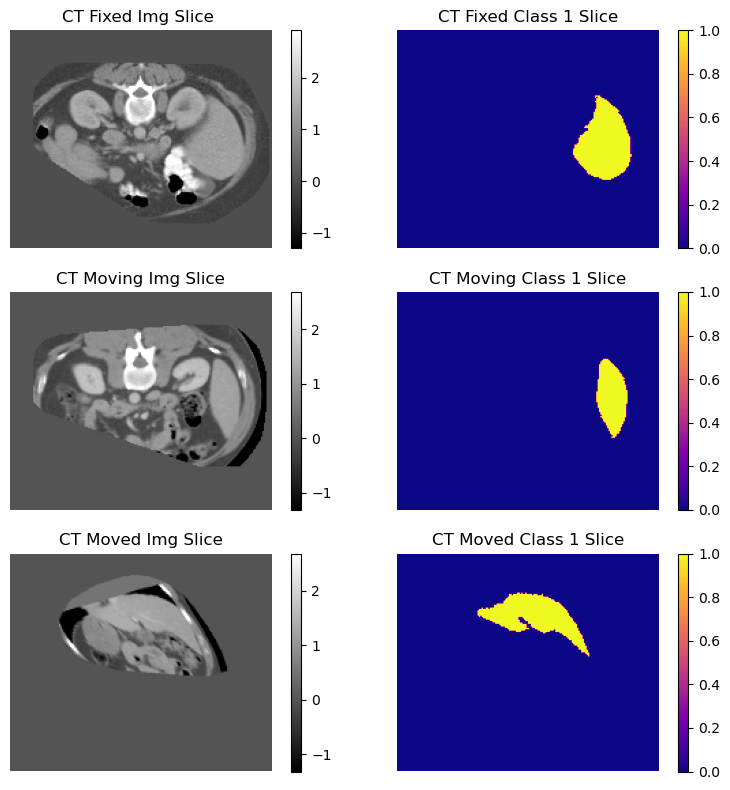

In [54]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

fixed_img = I_a_batch.cpu().squeeze()
fixed_seg = seg_a_batch.cpu().squeeze()
moving_img = I_b_batch.cpu().squeeze()
moving_seg = seg_b_batch.cpu().squeeze()
moved_img = transformed_img_b.detach().cpu().squeeze()
moved_seg = transformed_seg_b.detach().cpu().squeeze()



# Manually assign images and titles
im1 = axes[0, 0].imshow(fixed_img[100,:,:], cmap='gray')
axes[0, 0].set_title("CT Fixed Img Slice ")
axes[0, 0].axis('off')
fig.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(fixed_seg[1,100,:,:], cmap='plasma')
axes[0, 1].set_title("CT Fixed Class 1 Slice")
axes[0, 1].axis('off')
fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 0].imshow(moving_img[100,:,:], cmap='gray')
axes[1, 0].set_title("CT Moving Img Slice")
axes[1, 0].axis('off')
fig.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(moving_seg[1,100,:,:], cmap='plasma')
axes[1, 1].set_title("CT Moving Class 1 Slice")
axes[1, 1].axis('off')
fig.colorbar(im4, ax=axes[1, 1])

im5 = axes[2, 0].imshow(moved_img[100,:,:], cmap='gray')
axes[2, 0].set_title("CT Moved Img Slice")
axes[2, 0].axis('off')
fig.colorbar(im5, ax=axes[2, 0])

im6 = axes[2, 1].imshow(moved_seg[1,100,:,:], cmap='plasma')
axes[2, 1].set_title("CT Moved Class 1 Slice")
axes[2, 1].axis('off')
fig.colorbar(im6, ax=axes[2, 1])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [12]:
print(len(MR_paired_img))
print(len(CT_paired_img))

8
8


In [ ]:
 def dice_score(pred, target, num_classes=5, smooth=1e-5):
    """
    Compute the Dice loss for 3D multi-class segmentation.

    Args:
        pred (Tensor): Predicted segmentation map (B x 1 x D x H x W)
        target (Tensor): Ground truth segmentation map (B x 1 x D x H x W)
        num_classes (int): Number of classes (default 5)
        smooth (float): Smoothing factor to avoid division by zero

    Returns:
        float: Average Dice loss over all classes.
    """
    # Flatten the tensor into a 2D shape (B x (D*H*W)) for easy calculation of intersections
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    # Convert to long type for class comparison
    pred = pred.long()
    target = target.long()

    dice_scores = []

    for class_id in range(num_classes):
        # Create binary masks for each class
        pred_class = (pred == class_id).float()
        target_class = (target == class_id).float()

        # Compute intersection and union
        intersection = torch.sum(pred_class * target_class)
        union = torch.sum(pred_class) + torch.sum(target_class)

        # Compute Dice score for this class
        dice_score = (2 * intersection + smooth) / (union + intersection + smooth)
        dice_scores.append(dice_score)

    # Average the Dice scores across all classes
    avg_dice_score = torch.mean(torch.stack(dice_scores))
    return avg_dice_score

In [9]:
# Functions for preparing data for training

def random_affine_parameters():
    """
    Generate random affine transformation parameters within specified limits.

    Returns:
        torch.Tensor: A length-6 tensor representing the affine transformation parameters:
                      [rotation, scaling, shear_x, shear_y, translation_x, translation_y].
    """
    rotation = np.radians(random.uniform(-10, 10))  # Convert degrees to radians
    scaling = random.uniform(0.8, 1.2)  # Scaling coefficient
    shear_x = random.uniform(-0.05, 0.05)  # Shearing coefficient (5%)
    shear_y = random.uniform(-0.05, 0.05)
    translation_x = random.uniform(-0.05 * 192, 0.05 * 192)  # 5% of image width
    translation_y = random.uniform(-0.05 * 192, 0.05 * 192)  # 5% of image height
    
    return torch.tensor([rotation, scaling, shear_x, shear_y, translation_x, translation_y], dtype=torch.float32)

def apply_affine_transformation(slice_2d, phi):
    """
    Apply an affine transformation to a 2D image slice.

    Args:
        slice_2d (torch.Tensor): 2D tensor of shape (H, W) representing the image slice.
        phi (torch.Tensor): Length-6 tensor describing the affine transformation.

    Returns:
        torch.Tensor: The transformed 2D tensor.
    """   
    rotation, scaling, shear_x, shear_y, translation_x, translation_y = phi.tolist()
    
    # Construct the affine transformation matrix
    transformation_matrix = torch.tensor([
        [scaling * np.cos(rotation) + shear_x, shear_y, translation_x],
        [shear_x, scaling * np.cos(rotation) + shear_y, translation_y],
    ], dtype=torch.float32)
    
    # Apply affine transformation
    # Note: PyTorch expects shear in degrees, and translation as pixel offsets
    affine_transformed = TF.affine(
        img=slice_2d.unsqueeze(0),  # Convert to 1-channel
        angle=np.degrees(rotation),  # Angle in degrees
        translate=[translation_x, translation_y],  # Translation offsets
        scale=scaling,
        shear=[shear_x * 100, shear_y * 100]  # Shear as percentages
    )
    return affine_transformed.squeeze(0)

def affine_train_generator(image_list_1, image_list_2, batch_size=1):
    """
    A generator that yields batches of (I_a, I_b, phi).

    Args:
        image_list_1 (list of torch.Tensor): List of 3D tensors (192x160x192).
        image_list_2 (list of torch.Tensor): List of 3D tensors (192x160x192).
        batch_size (int): Number of samples per batch.

    Yields:
        I_a: A 2D slice of shape (H, W).
        I_b: The transformed version of I_a.
        phi: The affine transformation parameters as a length-6 tensor.
    """
    while True:
        I_a_batch, I_b_batch, phi_batch = [], [], []

        for _ in range(batch_size):
            # Randomly select a 3D tensor from the two input lists
            tensor_list = random.choice([image_list_1, image_list_2])
            tensor = random.choice(tensor_list)
            
            # Randomly select a slice index
            slice_index = random.randint(0, tensor.shape[1] - 1)  # Middle dimension
            
            # Extract the 2D slice
            I_a = tensor[:, slice_index, :]
            
            # Generate random affine transformation parameters
            phi = random_affine_parameters()
            
            # Apply affine transformation
            I_b = apply_affine_transformation(I_a, phi)
            
            # Append to the batch
            I_a_batch.append(I_a)
            I_b_batch.append(I_b)
            phi_batch.append(phi)
        
        # Stack the batch
        yield torch.stack(I_a_batch), torch.stack(I_b_batch), torch.stack(phi_batch)
        

def paired_slice_generator(image_list_1, image_list_2, seg_list_1, seg_list_2, mode="paired", batch_size=1, deterministic=False):
    """
    A generator that yields batches of paired 2D slices (I_a, I_b), optionally deterministic for specific batch numbers.
    
    Args:
        image_list_1 (list of torch.Tensor): List of 3D tensors (H x D x W).
        image_list_2 (list of torch.Tensor): List of 3D tensors (H x D x W).
        mode (str): Selection mode, either "random" or "paired".
        batch_size (int): Number of samples per batch.
        deterministic (bool): If True, allows reproducible results for specific batch numbers.
    
    Yields:
        Tuple: Batch of slices (I_a_batch, I_b_batch).
        I_a_batch (torch.Tensor): Batch of slices from list 1, shape [batch_size, H, W].
        I_b_batch (torch.Tensor): Batch of slices from list 2, shape [batch_size, H, W].
    """
    if len(image_list_1) != len(image_list_2):
        raise ValueError("Both image lists must have the same number of images.")
    
    num_images = len(image_list_1)

    batch_number = 0  # Counter for deterministic mode

    while True:
        if deterministic:
            random.seed(batch_number)  # Set seed for reproducibility
            batch_number += 1  # Increment for the next deterministic batch
        
        I_a_batch, I_b_batch, seg_a_batch, seg_b_batch = [], [], [], []

        for _ in range(batch_size):
            if mode == "random":
                # Randomly select an image from the lists
                img_idx = random.randint(0, num_images - 1)
                
                # Randomly select a slice index
                slice_idx = random.randint(0, image_list_1[img_idx].shape[1] - 1)
            elif mode == "paired":
                # Use the same index for paired images
                img_idx = random.randint(0, num_images - 1)
                slice_idx = random.randint(0, image_list_1[img_idx].shape[1] - 1)
            else:
                raise ValueError("Mode must be 'random' or 'paired'.")
            
            # Get the paired slices
            I_a = image_list_1[img_idx][:, slice_idx, :]
            I_b = image_list_2[img_idx][:, slice_idx, :]
            seg_a = seg_list_1[img_idx][:, slice_idx, :]
            seg_b = seg_list_2[img_idx][:, slice_idx, :]
            
            # Add to the batch
            I_a_batch.append(I_a)
            I_b_batch.append(I_b)
            seg_a_batch.append(seg_a)
            seg_b_batch.append(seg_b)
        
        # Stack the slices into batches
        yield torch.stack(I_a_batch), torch.stack(I_b_batch), torch.stack(seg_a_batch), torch.stack(seg_b_batch)
        

def paired_volume_generator(image_list_1, image_list_2, seg_list_1, seg_list_2, mode="paired", batch_size=1, deterministic=True):
    """
    A generator that yields batches of paired 3D volumes (I_a, I_b) and their corresponding segmentation masks.
    
    Args:
        image_list_1 (list of torch.Tensor): List of 3D tensors (D x H x W) for image 1.
        image_list_2 (list of torch.Tensor): List of 3D tensors (D x H x W) for image 2.
        seg_list_1 (list of torch.Tensor): List of 3D tensors (D x H x W) for segmentation mask 1.
        seg_list_2 (list of torch.Tensor): List of 3D tensors (D x H x W) for segmentation mask 2.
        mode (str): Selection mode, either "random" or "paired".
        batch_size (int): Number of samples per batch.
        deterministic (bool): If True, allows reproducible results for specific batch numbers.
    
    Yields:
        Tuple: Batch of 3D volumes (I_a_batch, I_b_batch, seg_a_batch, seg_b_batch).
        I_a_batch (torch.Tensor): Batch of 3D images from list 1, shape [batch_size, D, H, W].
        I_b_batch (torch.Tensor): Batch of 3D images from list 2, shape [batch_size, D, H, W].
        seg_a_batch (torch.Tensor): Batch of 3D segmentation masks from list 1, shape [batch_size, D, H, W].
        seg_b_batch (torch.Tensor): Batch of 3D segmentation masks from list 2, shape [batch_size, D, H, W].
    """
    if len(image_list_1) != len(image_list_2):
        raise ValueError("Both image lists must have the same number of images.")
    
    num_images = len(image_list_1)
    batch_number = 0  # Counter for deterministic mode

    while True:
        if deterministic:
            random.seed(batch_number)  # Set seed for reproducibility
            batch_number += 1  # Increment for the next deterministic batch
        
        I_a_batch, I_b_batch, seg_a_batch, seg_b_batch = [], [], [], []

        for _ in range(batch_size):
            if mode == "random":
                # Randomly select an image from the lists
                img_idx = random.randint(0, num_images - 1)
            elif mode == "paired":
                # Use the same index for paired images
                img_idx = random.randint(0, num_images - 1)
            else:
                raise ValueError("Mode must be 'random' or 'paired'.")
            
            # Get the paired 3D volumes (all slices for each image)
            I_a = image_list_1[img_idx]  # Shape: [D, H, W]
            I_b = image_list_2[img_idx]  # Shape: [D, H, W]
            seg_a = seg_list_1[img_idx]  # Shape: [D, H, W]
            seg_b = seg_list_2[img_idx]  # Shape: [D, H, W]
            
            I_a = I_a.permute(1, 0, 2)
            I_b = I_b.permute(1, 0, 2)
            seg_a = seg_a.permute(1, 0, 2)
            seg_b = seg_b.permute(1, 0, 2)
            
            # Add to the batch
            I_a_batch.append(I_a)
            I_b_batch.append(I_b)
            seg_a_batch.append(seg_a)
            seg_b_batch.append(seg_b)
            
        out1 = torch.stack(I_a_batch)
        out2 = torch.stack(I_b_batch)
        out3 = torch.stack(seg_a_batch)
        out4 = torch.stack(seg_b_batch)
            
        if batch_size == 1:
            out1 = out1.squeeze()
            out2 = out2.squeeze()
            out3 = out3.squeeze()
            out4 = out4.squeeze()
        
        # Stack the 3D volumes into batches (shape: [batch_size, D, H, W])
        yield out1, out2, out3, out4
        
class IndexedGenerator:
    def __init__(self, generator_function):
        """
        Wrap a generator function to allow indexed access to its yields.
        
        Args:
            generator_function (callable): A generator function.
        """
        self.generator = generator_function
        self.cache = []  # Cache to store results
        self.index = 0   # Tracks the current index in the generator

    def __getitem__(self, idx):
        """
        Get the nth yield from the generator, caching results for reuse.
        
        Args:
            idx (int): The index of the yield to retrieve.
        
        Returns:
            The generated item at the specified index.
        """
        if idx < 0:
            raise ValueError("Index must be non-negative.")

        # Generate and cache values up to the requested index
        while len(self.cache) <= idx:
            try:
                self.cache.append(next(self.generator))
            except StopIteration:
                raise IndexError("Generator has been exhausted.")
        
        return self.cache[idx]

    def next(self):
        """
        Get the next item from the generator, advancing the current index.
        
        Returns:
            The next item from the generator.
        """
        value = self[self.index]
        self.index += 1
        return value


torch.Size([160, 192, 192])
[0. 1. 2. 3. 4.]


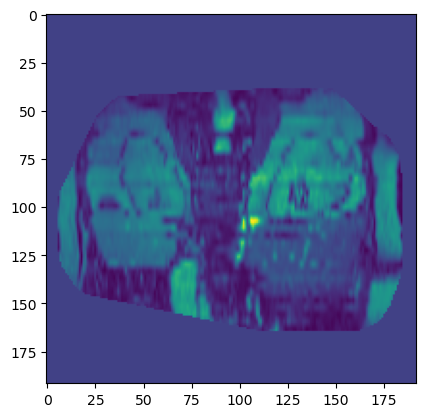

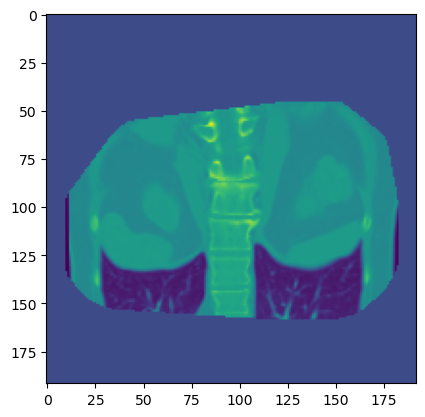

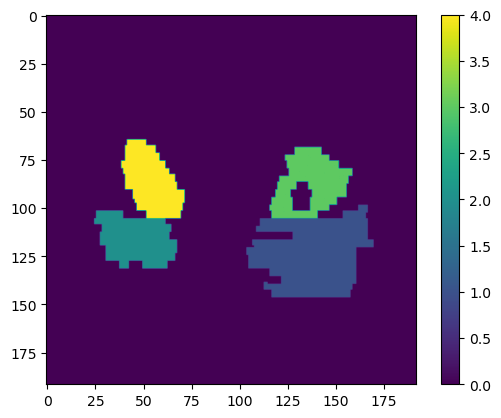

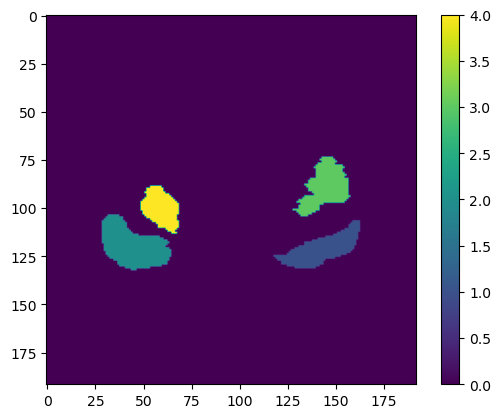

In [10]:
# Test affine train generator

tps_train_gen = paired_volume_generator(MR_paired_img, CT_paired_img, MR_paired_seg, CT_paired_seg, mode="paired", batch_size=1, deterministic=True)

indexed_data_gen = IndexedGenerator(tps_train_gen)

I_a, I_b, seg_a, seg_b = indexed_data_gen[18]
print(I_a.shape)
print(np.unique(seg_b))
plt.figure()
plt.imshow(I_a[51,:,:].squeeze())
plt.figure()
plt.imshow(I_b[51,:,:].squeeze())
plt.figure()
plt.imshow(seg_a[51,:,:].squeeze())
plt.colorbar()
plt.figure()
plt.imshow(seg_b[51,:,:].squeeze())
plt.colorbar()

In [11]:
# Model type
resnet = models.resnet50(pretrained=True)

resnet.conv1 = nn.Conv2d(1, resnet.conv1.out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

############################# Feature Extraction ##############################################

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        """
        Initializes the FeatureExtractor using a pre-trained ResNet50 model (or any model passed in),
        cropped at the 3rd layer, to process both I_a and I_b simultaneously.
        
        Args:
            model (nn.Module): A pre-trained model (e.g., ResNet50) passed during initialization.
        """
        super(FeatureExtractor, self).__init__()
        
        # The model is already passed, so no need to load it here
        self.features = nn.Sequential(*list(model.children())[:7])  # Keep layers up to the 4th block
        
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, I_a, I_b):
        """
        Forward pass for feature extraction on two 2D slices I_a and I_b using the same weights.
        
        Args:
            I_a (Tensor): A tensor of shape (batch_size, 1, 192, 192), representing the 2D slice of I_a.
            I_b (Tensor): A tensor of shape (batch_size, 1, 192, 192), representing the 2D slice of I_b.
        
        Returns:
            Tuple: The extracted features for I_a and I_b after passing through the network.
                - features_a (Tensor): Extracted features for I_a.
                - features_b (Tensor): Extracted features for I_b.
        """
        I_a = I_a.unsqueeze(0)  # Shape: (1, 1, 192, 192)
        I_b = I_b.unsqueeze(0)  # Shape: (1, 1, 192, 192)
        
        # Pass I_a through the model
        features_a = self.features(I_a)  # Shape: (batch_size, feature_size, H', W')
        
        # Pass I_b through the model
        features_b = self.features(I_b)  # Shape: (batch_size, feature_size, H', W')
        
        return features_a, features_b
    

#################################### Correlation Matrix ########################################
    
class CorrelationLayer(nn.Module):
    def __init__(self, num_features=1024):
        """
        Initialize the CorrelationLayer with batch normalization for the feature maps.
        
        Args:
            num_features (int): The number of features in the feature maps (default is 2048).
        """
        super(CorrelationLayer, self).__init__()
        
        # Batch normalization layer for the feature maps
        self.batch_norm = nn.BatchNorm2d(num_features)

    def forward(self, features_a, features_b):
        """
        Perform the forward pass: Apply ReLU, batch normalization, and compute the correlation matrix.
        
        Args:
            features_a (Tensor): Feature map from image A, shape [B, C, H, W].
            features_b (Tensor): Feature map from image B, shape [B, C, H, W].
            
        Returns:
            Tensor: The correlation matrix, shape [H, W, H, W].
        """
        # Apply ReLU activation to both feature maps
        features_a = F.relu(features_a)
        features_b = F.relu(features_b)
        
        # Apply batch normalization to both feature maps along the feature dimension (2048)
        features_a = self.batch_norm(features_a)
        features_b = self.batch_norm(features_b)
        
        # Get batch size, number of channels (features), height, and width
        B, C, H, W = features_a.shape
        
        # Reshape the feature maps to (B, C, H*W)
        features_a_reshaped = features_a.view(B, C, -1)  # Shape: [B, C, H*W]
        features_b_reshaped = features_b.view(B, C, -1)  # Shape: [B, C, H*W]
        
        # Compute the pairwise correlations via matrix multiplication
        # features_a_reshaped and features_b_reshaped both have shape [B, C, H*W]
        # Transpose features_b_reshaped to align the features for the dot product
        correlation_matrix = torch.matmul(features_a_reshaped.transpose(1, 2), features_b_reshaped)  # Shape: [H*W, H*W]
        
        # Reshape the result into a 3D tensor (H, W, H*W) where depth is H*W
        correlation_matrix = correlation_matrix.view(H, W, H*W)
        
        correlation_matrix = correlation_matrix.unsqueeze(0)
        
        return correlation_matrix
    

######################################## Regression Network ##############################################

class RegressionNetwork(nn.Module):
    def __init__(self, input_channels=144, num_outputs=6):
        """
        Initialize the Regression Network.
        
        Args:
            input_channels (int): The number of input channels (default is 144).
            num_outputs (int): The number of output values (default is 6, for affine parameters, for TPS use 72).
        """
        super(RegressionNetwork, self).__init__()
        
        # First 2D convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels=input_channels, 
            out_channels=128, 
            kernel_size=7, 
            stride=1, 
            padding=2  # 1 padding
        )
        self.bn1 = nn.BatchNorm2d(128)  # Batch normalization for the first conv layer
        
        # Second 2D convolutional layer
        self.conv2 = nn.Conv2d(
            in_channels=128, 
            out_channels=64, 
            kernel_size=5, 
            stride=1, 
            padding=1  # 1 padding
        )
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for the second conv layer
        
        # Fully connected layer
        # The input dimensions of the fully connected layer are determined by the final spatial size
        self.fc = nn.Linear(64 * 8 * 8, num_outputs)  # Adjust based on spatial size after conv2

    def forward(self, x):
        """
        Perform the forward pass through the network.
        
        Args:
            x (Tensor): Input tensor of shape [B, C, H, W].
            
        Returns:
            Tensor: Output tensor of shape [B, num_outputs].
        """
        x = x.permute(0, 3, 1, 2)  # Change from [B, H, W, C] to [B, C, H, W]
        
        # First conv layer
        x = self.conv1(x)  # Shape: [B, 128, H, W]
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second conv layer
        x = self.conv2(x)  # Shape: [B, 64, H-4, W-4] (reduced size due to no padding)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Flatten for the fully connected layer
        x = torch.flatten(x, start_dim=1)  # Shape: [B, 64 * (H-4) * (W-4)]
        
        # Fully connected layer
        x = self.fc(x)  # Shape: [B, num_outputs]
        
        return x
    

######################################### Affine and TPS transforms #######################################################
    
class AffineTransform(nn.Module):
    def __init__(self, scale_factor=0.1):
        """
        Initialize the affine transformation module.
        
        Args:
            scale_factor (float): Scaling factor to control the influence of theta on the transformation.
        """
        super(AffineTransform, self).__init__()
        self.scale_factor = scale_factor  # Scaling factor for theta
        self.identity = torch.eye(2)  # 2x2 Identity matrix

    def forward(self, theta, grid_size):
        """
        Compute the affine transformation and generate the transformed grid.
        
        Args:
            theta (Tensor): A tensor of shape [B, 6], where each row is [theta_0, ..., theta_5].
            grid_size (tuple): The spatial size of the input image (height, width).
            
        Returns:
            Tensor: Transformed grid for sampling, shape [B, H, W, 2].
        """
        batch_size = theta.shape[0]

        # Reshape theta into components
        theta_matrix = theta[:, :4].view(-1, 2, 2)  # [B, 2, 2]
        translation = theta[:, 4:].view(-1, 2, 1)  # [B, 2, 1]

        # Apply the scaling factor and add the identity matrix
        affine_matrix = self.scale_factor * theta_matrix + self.identity.to(theta.device)  # [B, 2, 2]

        # Concatenate the translation to form a full 2x3 affine matrix
        affine_matrix = torch.cat([affine_matrix, self.scale_factor * translation], dim=-1)  # [B, 2, 3]

        # Create a sampling grid based on the affine matrix
        grid = F.affine_grid(affine_matrix, size=(batch_size, 1, grid_size[0], grid_size[1]), align_corners=False)  # [B, H, W, 2]

        return grid

    def apply_transformation(self, image, grid):
        """
        Apply the computed affine transformation to the input image.
        
        Args:
            image (Tensor): Input image of shape [B, 1, H, W].
            grid (Tensor): Sampling grid of shape [B, H, W, 2].
            
        Returns:
            Tensor: Transformed image of shape [B, 1, H, W].
        """
        if image.dim() == 3:
            image = image.unsqueeze(0)  # Add a batch dimension
        
        transformed_image = F.grid_sample(image, grid, mode='bilinear', padding_mode='zeros', align_corners=False)
        return transformed_image
    
# class TPSTransform(nn.Module):
#     def __init__(self, scale_factor=1.0):
#         super(TPSTransform, self).__init__()
#         self.scale_factor = scale_factor  # Scaling factor for warping

#     def forward(self, theta, image_size=(192, 192)):
#         """
#         Args:
#             theta: Tensor of shape (batch_size, 72) representing the displacement parameters
#             image_size: Tuple representing the image size (height, width)

#         Returns:
#             grid: The warped grid, a tensor of shape (batch_size, H, W, 2)
#         """
#         batch_size = theta.size(0)
        
        
#         # Generate the 6x6 control points grid
#         control_points = self._generate_control_points(image_size)
        
#         # Reshape theta to (batch_size, 36, 2) for easier indexing
#         theta = theta.view(batch_size, 36, 2)
        
#         control_points = control_points.cuda()
#         theta = theta.cuda()
        
#         # Apply the displacements to control points
#         warped_control_points = control_points + theta
        
#         # Convert the control points to a SimpleITK image and apply TPS interpolation
#         grid = self._tps_interpolate(warped_control_points, control_points, image_size)
        
#         return grid

#     def _generate_control_points(self, image_size):
#         """
#         Generate the fixed 6x6 control points for the TPS transformation.
#         These are evenly spaced across the image.
        
#         Args:
#             image_size: Tuple representing the image size (height, width)

#         Returns:
#             control_points: Tensor of shape (36, 2) for 6x6 grid of control points
#         """
        
#         H, W = image_size
#         x_vals = torch.linspace(0, W-1, 6)  # 6 points evenly spaced in width
#         y_vals = torch.linspace(0, H-1, 6)  # 6 points evenly spaced in height
        
#         grid_x, grid_y = torch.meshgrid(x_vals, y_vals)
#         control_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
#         return control_points  # Shape (36, 2)

#     def _tps_interpolate(self, warped_control_points, control_points, image_size):
#         """
#         Use the Thin-Plate Spline interpolation to compute the warped grid.

#         Args:
#             warped_control_points: The new, displaced control points (batch_size, 36, 2)
#             control_points: The original control points (36, 2)
#             image_size: Tuple representing the image size (height, width)

#         Returns:
#             grid: The warped grid, a tensor of shape (batch_size, H, W, 2)
#         """
        
#         H, W = image_size
#         batch_size = warped_control_points.size(0)
        
#         # Convert control points and warped control points to SimpleITK images
#         # Convert to numpy arrays as SimpleITK uses numpy
#         control_points = control_points.cpu()
#         control_points_np = control_points.numpy()  # Shape (36, 2)
#         warped_control_points_np = warped_control_points.numpy()  # Shape (batch_size, 36, 2)
        
#         # Create a SimpleITK image to resample
#         # The control points need to be mapped to an image space, we do this by defining a displacement field
        
#         grid = torch.zeros(batch_size, H, W, 2).to(warped_control_points.device)
        
#         for i in range(batch_size):
#             # Create a SimpleITK displacement field from the warped control points
#             displacement_field = sitk.Image(W, H, sitk.sitkVectorFloat64)  # Create an empty displacement field
#             displacement_field_array = np.zeros((H, W, 2), dtype=np.float64)  # Initialize an empty displacement array
            
#             # Apply the displacements from warped_control_points to the displacement field
#             for j in range(len(warped_control_points[i])):
#                 x, y = control_points_np[j]
#                 dx, dy = warped_control_points_np[i, j]
#                 # Apply displacement to the appropriate position in the displacement field
#                 displacement_field_array[int(y), int(x), 0] = dx - x  # x displacement
#                 displacement_field_array[int(y), int(x), 1] = dy - y  # y displacement

#             # Transfer the displacement field to SimpleITK Image
#             sitk_displacement_field = sitk.GetImageFromArray(displacement_field_array)
            
#             # Create an identity transform and apply the displacement field
#             identity_transform = sitk.Transform(2, sitk.sitkIdentity)
#             resampled_image = sitk.Resample(
#                 sitk.GetImageFromArray(np.zeros((H, W), dtype=np.float64)),
#                 sitk_displacement_field,
#                 identity_transform,
#                 sitk.sitkLinear,
#                 0.0,
#                 sitk.GetImageFromArray(np.zeros((H, W), dtype=np.float64))
#             )
            
#             # Store the resulting grid
#             grid[i] = torch.tensor(sitk.GetArrayFromImage(resampled_image)).to(warped_control_points.device)

#         return grid
    
#     def apply_transformation(self, image, grid, mode='bilinear'):
#         """
#         Apply the computed TPS transformation to the input image.
        
#         Args:
#             image (Tensor): Input image of shape [B, 1, H, W].
#             grid (Tensor): Sampling grid of shape [B, H, W, 2].
#             mode (str): Interpolation mode. 'bilinear' for images and 'nearest' for labels.
            
#         Returns:
#             Tensor: Transformed image of shape [B, 1, H, W].
#         """
#         if image.dim() == 3:
#             image = image.unsqueeze(0)  # Add a batch dimension if missing
        
#         # Apply the transformation using grid_sample
#         transformed_image = F.grid_sample(image, grid, mode=mode, padding_mode='zeros', align_corners=False)
        
#         return transformed_image

# class TPSTransform(nn.Module):
#     def __init__(self, scale_factor=1.0):
#         super(TPSTransform, self).__init__()
#         self.scale_factor = scale_factor  # Scaling factor for warping

#     def forward(self, theta, image_size=(192, 192)):
#         """
#         Args:
#             theta: Tensor of shape (batch_size, 72) representing the displacement parameters
#             image_size: Tuple representing the image size (height, width)

#         Returns:
#             grid: The warped grid, a tensor of shape (batch_size, H, W, 2)
#         """
#         batch_size = theta.size(0)
        
#         # Generate the 6x6 control points grid
#         control_points = self._generate_control_points(image_size)
        
#         # Reshape theta to (batch_size, 36, 2) for easier indexing
#         theta = theta.view(batch_size, 36, 2)
        
#         control_points = control_points.to(theta.device)  # Ensure control points are on the same device as theta
        
#         # Apply the displacements to control points
#         warped_control_points = control_points + theta
        
#         # Apply the TPS interpolation to get the warped grid
#         grid = self._tps_interpolate(warped_control_points, control_points, image_size)
        
#         return grid

#     def _generate_control_points(self, image_size):
#         """
#         Generate the fixed 6x6 control points for the TPS transformation.
#         These are evenly spaced across the image.
        
#         Args:
#             image_size: Tuple representing the image size (height, width)

#         Returns:
#             control_points: Tensor of shape (36, 2) for 6x6 grid of control points
#         """
        
#         H, W = image_size
#         x_vals = torch.linspace(0, W-1, 6)  # 6 points evenly spaced in width
#         y_vals = torch.linspace(0, H-1, 6)  # 6 points evenly spaced in height
        
#         grid_x, grid_y = torch.meshgrid(x_vals, y_vals)
#         control_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
#         return control_points  # Shape (36, 2)

#     def _tps_interpolate(self, warped_control_points, control_points, image_size):
#         """
#         Use the Thin-Plate Spline interpolation to compute the warped grid.

#         Args:
#             warped_control_points: The new, displaced control points (batch_size, 36, 2)
#             control_points: The original control points (36, 2)
#             image_size: Tuple representing the image size (height, width)

#         Returns:
#             grid: The warped grid, a tensor of shape (batch_size, H, W, 2)
#         """
        
#         H, W = image_size
#         batch_size = warped_control_points.size(0)
        
#         # Initialize the grid
#         grid = torch.zeros(batch_size, H, W, 2).to(warped_control_points.device)

#         # For each image in the batch, calculate the warped grid
#         for i in range(batch_size):
#             # Interpolate the warped control points across the image
#             for j in range(len(warped_control_points[i])):
#                 x, y = control_points[j]
#                 dx, dy = warped_control_points[i, j]
#                 # Apply displacement to the grid
#                 grid[i, int(y), int(x), 0] = dx - x  # x displacement
#                 grid[i, int(y), int(x), 1] = dy - y  # y displacement

#         return grid
    
#     def apply_transformation(self, image, grid, mode='bilinear'):
#         """
#         Apply the computed TPS transformation to the input image.
        
#         Args:
#             image (Tensor): Input image of shape [B, 1, H, W].
#             grid (Tensor): Sampling grid of shape [B, H, W, 2].
#             mode (str): Interpolation mode. 'bilinear' for images and 'nearest' for labels.
            
#         Returns:
#             Tensor: Transformed image of shape [B, 1, H, W].
#         """
#         if image.dim() == 3:
#             image = image.unsqueeze(0)  # Add a batch dimension if missing
        
#         # Apply the transformation using grid_sample
#         transformed_image = F.grid_sample(image, grid, mode=mode, padding_mode='zeros', align_corners=False)
        
#         return transformed_image


class TPSTransform(nn.Module):
    def __init__(self, scale_factor=1.0):
        super(TPSTransform, self).__init__()
        self.scale_factor = scale_factor  # Scaling factor for warping

    def forward(self, theta, image_size=(192, 192)):
        """
        Args:
            theta: Tensor of shape (batch_size, 72) representing the displacement parameters
            image_size: Tuple representing the image size (height, width)

        Returns:
            grid: The warped grid, a tensor of shape (batch_size, H, W, 2)
        """
        batch_size = theta.size(0)

        # Generate the 6x6 control points grid
        control_points = self._generate_control_points(image_size)
        
        # Reshape theta to (batch_size, 36, 2) for easier indexing
        theta = theta.view(batch_size, 36, 2)
        
        control_points = control_points.to(theta.device)  # Ensure control points are on the same device as theta
        
        # Apply the displacements to control points
        warped_control_points = control_points + theta
        
        # Apply the TPS interpolation to get the warped grid
        grid = self._tps_interpolate(warped_control_points, control_points, image_size)
        
        # Normalize the grid to [-1, 1] range for grid_sample
        grid = 2.0 * grid / torch.tensor([image_size[1]-1, image_size[0]-1], dtype=torch.float32).to(grid.device) - 1.0
        
        return grid

    def _generate_control_points(self, image_size):
        """
        Generate the fixed 6x6 control points for the TPS transformation.
        These are evenly spaced across the image.
        
        Args:
            image_size: Tuple representing the image size (height, width)

        Returns:
            control_points: Tensor of shape (36, 2) for 6x6 grid of control points
        """
        
        H, W = image_size
        x_vals = torch.linspace(0, W-1, 6)  # 6 points evenly spaced in width
        y_vals = torch.linspace(0, H-1, 6)  # 6 points evenly spaced in height
        
        grid_x, grid_y = torch.meshgrid(x_vals, y_vals)
        control_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
        return control_points  # Shape (36, 2)

    def _tps_interpolate(self, warped_control_points, control_points, image_size):
        """
        Use the Thin-Plate Spline interpolation to compute the warped grid.

        Args:
            warped_control_points: The new, displaced control points (batch_size, 36, 2)
            control_points: The original control points (36, 2)
            image_size: Tuple representing the image size (height, width)

        Returns:
            grid: The warped grid, a tensor of shape (batch_size, H, W, 2)
        """
        
        H, W = image_size
        batch_size = warped_control_points.size(0)
        
        # Initialize the grid
        grid = torch.zeros(batch_size, H, W, 2).to(warped_control_points.device)

        # Flatten grid to create the interpolation grid
        grid_x, grid_y = torch.meshgrid(torch.arange(0, W), torch.arange(0, H))
        grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(warped_control_points.device)
        
        # Compute the RBF matrix for each grid point
        rbf_matrix = self._compute_tps_rbf(grid_points, control_points)  # (num_grid_points, 36)
        
        # Apply the RBF matrix to warp the grid points
        # warped_grid = rbf_matrix @ warped_control_points.view(-1, 2)  # (num_grid_points, 2)
        warped_grid = torch.matmul(rbf_matrix, warped_control_points.view(-1, 2))  # Shape: [num_grid_points, 2]

        # Reshape into the correct grid shape for [batch_size, H, W, 2]
        grid = warped_grid.view(batch_size, H, W, 2)

        return grid
    
    def _compute_tps_rbf(self, grid_points, control_points, a=0.1, b=50.0):
        """
        Compute the Radial Basis Function (RBF) using a sigmoid kernel for thin-plate splines.

        Args:
            grid_points (Tensor): Points where we want to apply the transformation (num_grid_points, 2).
            control_points (Tensor): Control points for the transformation (num_control_points, 2).
            a (float): Slope parameter for the sigmoid kernel.
            b (float): Offset parameter for the sigmoid kernel.

        Returns:
            Tensor: RBF matrix (num_grid_points, num_control_points)
        """
        # Ensure both grid_points and control_points are float tensors
        grid_points = grid_points.float()
        control_points = control_points.float()

        # Compute the Euclidean distance between each grid point and control point
        distances = torch.cdist(grid_points, control_points)  # Shape: (num_grid_points, num_control_points)

        # Apply the sigmoid kernel: 1 / (1 + exp(-a * (d - b)))
        rbf = 1.0 / (1.0 + torch.exp(-a * (distances - b)))

        return rbf

    def apply_transformation(self, image, grid, mode='bilinear'):
        """
        Apply the computed TPS transformation to the input image.
        
        Args:
            image (Tensor): Input image of shape [B, 1, H, W].
            grid (Tensor): Sampling grid of shape [B, H, W, 2].
            mode (str): Interpolation mode. 'bilinear' for images and 'nearest' for labels.
            
        Returns:
            Tensor: Transformed image of shape [B, 1, H, W].
        """
        if image.dim() == 3:
            image = image.unsqueeze(0)  # Add a batch dimension if missing
        
        # Apply the transformation using grid_sample
        transformed_image = F.grid_sample(image, grid, mode=mode, padding_mode='zeros', align_corners=False)
        
        return transformed_image


    
##################################### Loss Functions ####################################################
    
class AffineMSELoss(nn.Module):
    def __init__(self, affine_transform_module):
        """
        Initialize the MSE loss module with an affine transform module.
        
        Args:
            affine_transform_module (nn.Module): The module that applies the affine transformation.
        """
        super(AffineMSELoss, self).__init__()
        self.affine_transform = affine_transform_module
        self.mse_loss = nn.MSELoss()

    def forward(self, I_a, I_b, theta):
        """
        Compute the MSE loss between the transformed I_a and the original I_b.
        
        Args:
            I_a (Tensor): Input image A, shape [B, 1, H, W].
            I_b (Tensor): Target image B, shape [B, 1, H, W].
            theta (Tensor): Affine transformation parameters, shape [B, 6].
        
        Returns:
            Tensor: The computed MSE loss.
        """
        # Compute the transformation grid
        if I_a.dim() == 3:
            I_a = I_a.unsqueeze(0)  # Add a batch dimension
        if I_b.dim() == 3:
            I_b = I_b.unsqueeze(0)  # Add a batch dimension
        
        grid = self.affine_transform(theta, grid_size=I_a.shape[2:])
        
        # Transform I_a using the affine transformation
        transformed_I_a = self.affine_transform.apply_transformation(I_a, grid)
        
        # Compute and return the MSE loss
        loss = self.mse_loss(transformed_I_a, I_b)
        return loss
    
    
class TPSCombinedLoss(nn.Module):
    def __init__(self, tps_transform_module, image_weight=0.5, label_weight=0.5):
        """
        Initialize the loss module with the TPS transform module and weights for MSE and Dice losses.
        
        Args:
            tps_transform_module (nn.Module): The module that applies the TPS transformation.
            image_weight (float): Weight for the image MSE loss.
            label_weight (float): Weight for the multiclass Dice loss.
        """
        super(TPSCombinedLoss, self).__init__()
        self.tps_transform = tps_transform_module
        self.mse_loss = nn.SmoothL1Loss()  # For image similarity
        self.image_weight = image_weight
        self.label_weight = label_weight

    def forward(self, I_a, I_b, theta, labels, target_labels):
        """
        Compute the combined loss (MSE loss for images + Dice loss for label masks).
        
        Args:
            I_a (Tensor): Input image A, shape [B, 1, H, W].
            I_b (Tensor): Target image B, shape [B, 1, H, W].
            theta (Tensor): TPS transformation parameters, shape [B, 72].
            labels (Tensor): Transformed label mask, shape [B, C, H, W].
            target_labels (Tensor): Ground truth label mask, shape [B, C, H, W].
            
        
        Returns:
            Tensor: The combined MSE + Dice loss.
        """
        # Apply the TPS transformation to get the deformed grid
        grid = self.tps_transform(theta, image_size=I_a.shape[1:])

        # Apply the TPS transformation to both the image and label masks
        transformed_I_a = self.tps_transform.apply_transformation(I_a, grid, mode='bilinear')
        transformed_labels = self.tps_transform.apply_transformation(labels, grid, mode='nearest')
        
       
        
        # Compute MSE loss between the transformed image and the target image
        image_loss = self.mse_loss(transformed_I_a, I_b)
        

        # Compute the multiclass Dice loss for label masks
        dice_loss_value = self.multiclass_dice_loss(transformed_labels, target_labels)
        
        image_loss = torch.where(torch.isnan(image_loss), torch.tensor(100.0, device=image_loss.device, requires_grad=True), image_loss)
        
        
        # Combine both losses
        total_loss = self.image_weight * image_loss + self.label_weight * dice_loss_value
        return total_loss

    def multiclass_dice_loss(self, preds, targets, num_classes=5, smooth=1e-6):
        """
        Compute the multiclass Dice loss for segmentation masks.

        Args:
            preds (Tensor): Predicted label masks (shape: [B, H, W, 1] or [B, 1, H, W]).
            targets (Tensor): Ground truth label masks (shape: [B, H, W, 1] or [B, H, W]).
            num_classes (int): Number of classes (including background).
            smooth (float): A small constant to avoid division by zero.

        Returns:
            Tensor: The computed multiclass Dice loss.
        """
         # Check if preds and targets are tensors
        if not isinstance(targets, torch.Tensor):
            raise TypeError(f"Expected targets to be a tensor, but got {type(targets)}")
        if not isinstance(preds, torch.Tensor):
            raise TypeError(f"Expected preds to be a tensor, but got {type(preds)}")

        # Remove unnecessary dimensions
        preds = preds.squeeze()  # Shape: [B, H, W]
        targets = targets.squeeze()  # Shape: [B, H, W]

        # Initialize Dice scores for each class
        batch_size = preds.size(0)
        dice_per_class = []

        for c in range(num_classes):
            # Create binary masks for the current class
            pred_class = (preds == c).float()  # Shape: [B, H, W]
            target_class = (targets == c).float()  # Shape: [B, H, W]
            
            pred_class = pred_class.unsqueeze(0)  # Add batch dimension: Shape becomes [1, 192, 192]
            target_class = target_class.unsqueeze(0)  # Add batch dimension: Shape becomes [1, 192, 192]
            # Compute intersection and union
            intersection = torch.sum(pred_class * target_class, dim=(1, 2))  # Shape: [B]
            union = torch.sum(pred_class, dim=(1, 2)) + torch.sum(target_class, dim=(1, 2))  # Shape: [B]

            # Compute Dice score for the current class
            dice = (2.0 * intersection + smooth) / (union + smooth)  # Shape: [B]
            dice_per_class.append(dice)

        # Stack class Dice scores and average
        dice_per_class = torch.stack(dice_per_class, dim=1)  # Shape: [B, num_classes]
        dice_loss = 1 - dice_per_class.mean()

        return dice_loss


/blue/eel6935/guzikjar/conda/envs/MedIm/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Affine Training and Test functions
def train_affine_transform_learner(
    feature_extractor, correlation_layer, regression_network, affine_transform, loss_fn,
    data_generator, optimizer, num_epochs=50, num_iterations=300
):
    """
    Train the affine transformation learner.

    Args:
        feature_extractor (nn.Module): The feature extraction module.
        correlation_layer (nn.Module): The correlation layer.
        regression_network (nn.Module): The regression network.
        affine_transform (nn.Module): The affine transformation module.
        loss_fn (nn.Module): The loss function (AffineMSELoss).
        data_generator (generator): Data generator yielding (I_a, I_b).
        optimizer (torch.optim.Optimizer): Optimizer for training.
        num_epochs (int): Number of epochs to train.
        num_iterations (int): Number of iterations per epoch.
    """
    epoch_losses = []  # List to store average losses per epoch
    
    feature_extractor.eval()  # Pre-trained feature extractor, set to eval mode
    correlation_layer.train()  # Correlation layer is trainable
    regression_network.train()  # Regression network is trainable
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for iteration in range(num_iterations):
            # Generate training data
            I_a, I_b, _ = next(data_generator)  # I_a, I_b are input tensors
            
            I_a = I_a.cuda() if torch.cuda.is_available() else I_a
            I_b = I_b.cuda() if torch.cuda.is_available() else I_b
            
            # Extract features
            features_a, features_b = feature_extractor(I_a, I_b)
            
            # Compute the correlation matrix
            correlation_map = correlation_layer(features_a, features_b)
            
            # Predict the affine transformation parameters (theta)
            theta = regression_network(correlation_map)
            
            # Compute the loss
            loss = loss_fn(I_a, I_b, theta)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_loss_loop = epoch_loss / num_iterations
        epoch_losses.append(avg_loss_loop)
        # Average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss / num_iterations:.4f}")
        
    return epoch_losses


class AffineTransformationTest(nn.Module):
    def __init__(self, feature_extractor, correlation_layer, regression_network, affine_transform):
        super(AffineTransformationTest, self).__init__()
        self.feature_extractor = feature_extractor
        self.correlation_layer = correlation_layer
        self.regression_network = regression_network
        self.affine_transform = affine_transform
        
    def forward(self, I_a, I_b):
        """
        Perform the forward pass without training: Apply the affine transformation and compute the loss.
        
        Args:
            I_a (Tensor): Image A (input), shape [1, C, H, W].
            I_b (Tensor): Image B (target), shape [1, C, H, W].
            
        Returns:
            Tuple: Loss value and transformed image.
        """
        self.eval()  # Set the model to evaluation mode
        
        with torch.no_grad():  # Disable gradient calculation during inference
            # Step 1: Extract features from both images using the feature extractor
            features_a, features_b = feature_extractor(I_a, I_b)
            
            correlation_map = correlation_layer(features_a, features_b)
            
            # Predict the affine transformation parameters (theta)
            theta = regression_network(correlation_map)
            
            # Compute the transformation grid
            if I_a.dim() == 3:
                I_a = I_a.unsqueeze(0)  # Add a batch dimension
            if I_b.dim() == 3:
                I_b = I_b.unsqueeze(0)  # Add a batch dimension
        
            grid = self.affine_transform(theta, grid_size=I_a.shape[2:])
            # Step 3: Apply the affine transformation to I_a to get I_a_transformed
            I_a_transformed = self.affine_transform.apply_transformation(I_a, grid)
            
            # Step 4: Calculate the loss between transformed I_a and I_b (e.g., using MSE loss)
            loss = F.mse_loss(I_a_transformed, I_b)  # MSE loss between transformed image and target
        
        return loss, I_a_transformed
    
    
##################################### TPS Network ###################################################
def train_tps_transform_learner(
    affine_net_test, feature_extractor, correlation_layer, regression_network, tps_transform, loss_fn,
    data_generator, optimizer, num_epochs=50, num_iterations=500
):
    """
    Train the affine transformation learner.

    Args:
        affine_net_test (nn.Module): The affine network from before
        feature_extractor (nn.Module): The feature extraction module.
        correlation_layer (nn.Module): The correlation layer.
        regression_network (nn.Module): The regression network.
        tps_transform (nn.Module): The tps transformation module.
        loss_fn (nn.Module): The loss function (AffineMSELoss).
        data_generator (generator): Data generator yielding (I_a, I_b).
        optimizer (torch.optim.Optimizer): Optimizer for training.
        num_epochs (int): Number of epochs to train.
        num_iterations (int): Number of iterations per epoch.
    """
    epoch_losses = []  # List to store average losses per epoch
    affine_net_test.eval()
    feature_extractor.train()  # Pre-trained feature extractor, set to eval mode
    correlation_layer.train()  # Correlation layer is trainable
    regression_network.train()  # Regression network is trainable
    # loss_fn.eval()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for iteration in range(num_iterations):
            # Generate training data
            I_a, I_b, seg_a, seg_b = next(data_generator)  # I_a, I_b are input tensors, seg_a, seg_b are for dice loss
            
            I_a = I_a.cuda() if torch.cuda.is_available() else I_a
            I_b = I_b.cuda() if torch.cuda.is_available() else I_b
            seg_a = seg_a.cuda() if torch.cuda.is_available() else seg_a
            seg_b = seg_b.cuda() if torch.cuda.is_available() else seg_b
            
            __, I_a_affine = affine_net_test(I_a, I_b)
            
            I_a_affine = torch.squeeze(I_a_affine, dim=0)
            
            I_a_affine = I_a_affine.cuda()
                        
            # Extract features
            features_a, features_b = feature_extractor(I_a_affine, I_b)
            
            # features_a = features_a.cuda()
            # features_b = features_b.cuda()
            
            # Compute the correlation matrix
            correlation_map = correlation_layer(features_a, features_b)
            
            # correlation_map = correlation_map.cuda()
            
            # Predict the affine transformation parameters (theta)
            theta = regression_network(correlation_map)
            
            theta = theta.cuda()
            
            
            
            # Compute the loss
            loss = loss_fn(I_a_affine, I_b, theta, seg_a, seg_b)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_loss_loop = epoch_loss / num_iterations
        epoch_losses.append(avg_loss_loop)
        # Average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss / num_iterations:.4f}")
        
    return epoch_losses



# class TPSTransformationTest(nn.Module):
#     def __init__(self, feature_extractor, correlation_layer, regression_network, affine_transform):
#         super(TPSTransformationTest, self).__init__()
#         self.feature_extractor = feature_extractor
#         self.correlation_layer = correlation_layer
#         self.regression_network = regression_network
#         self.affine_transform = affine_transform
        
#     def forward(self, I_a, I_b):
#         """
#         Perform the forward pass without training: Apply the affine transformation and compute the loss.
        
#         Args:
#             I_a (Tensor): Image A (input), shape [1, C, H, W].
#             I_b (Tensor): Image B (target), shape [1, C, H, W].
            
#         Returns:
#             Tuple: Loss value and transformed image.
#         """
#         self.eval()  # Set the model to evaluation mode
        
#         with torch.no_grad():  # Disable gradient calculation during inference
#             # Step 1: Extract features from both images using the feature extractor
#             features_a, features_b = feature_extractor(I_a, I_b)
            
#             correlation_map = correlation_layer(features_a, features_b)
            
#             # Predict the affine transformation parameters (theta)
#             theta = regression_network(correlation_map)
            
#             # Compute the transformation grid
#             if I_a.dim() == 3:
#                 I_a = I_a.unsqueeze(0)  # Add a batch dimension
#             if I_b.dim() == 3:
#                 I_b = I_b.unsqueeze(0)  # Add a batch dimension
        
#             grid = self.affine_transform(theta, grid_size=I_a.shape[2:])
#             # Step 3: Apply the affine transformation to I_a to get I_a_transformed
#             I_a_transformed = self.affine_transform.apply_transformation(I_a, grid)
            
#             # Step 4: Calculate the loss between transformed I_a and I_b (e.g., using MSE loss)
#             loss = F.mse_loss(I_a_transformed, I_b)  # MSE loss between transformed image and target
        
#         return loss, I_a_transformed
    

class FullTransformationTest(nn.Module):
    def __init__(self, affine_net_test, feature_extractor, correlation_layer, regression_network, tps_transform, loss_fn):
        """
        Initialize the test class for TPS-based transformation learner.

        Args:
            affine_net_test (nn.Module): The affine network.
            feature_extractor (nn.Module): The feature extraction module.
            correlation_layer (nn.Module): The correlation layer.
            regression_network (nn.Module): The regression network.
            tps_transform (nn.Module): The TPS transformation module.
            loss_fn (nn.Module): The loss function (AffineMSELoss).
        """
        super(FullTransformationTest, self).__init__()
        self.affine_net_test = affine_net_test
        self.feature_extractor = feature_extractor
        self.correlation_layer = correlation_layer
        self.regression_network = regression_network
        self.tps_transform = tps_transform
        self.loss_fn = loss_fn

    def test_slice(self, I_a, I_b, seg_a, seg_b):
        """
        Test the TPS transformation on a single slice (2D image).
        
        Args:
            I_a (Tensor): Input image slice A, shape [1, H, W].
            I_b (Tensor): Target image slice B, shape [1, H, W].
            seg_a (Tensor): Segmentation mask for image A, shape [1, H, W].
            seg_b (Tensor): Ground truth segmentation mask for image B, shape [1, H, W].
            
        Returns:
            float: The Dice score for the current slice.
            Tensor: The transformed image slice.
            Tensor: The transformed segmentation slice.
        """
        self.affine_net_test.eval()
        self.feature_extractor.eval()
        self.correlation_layer.eval()
        self.regression_network.eval()

        with torch.no_grad():  # Disable gradient computation for testing
            # Apply affine network to get I_a_affine
            __, I_a_affine = self.affine_net_test(I_a, I_b)
            I_a_affine = torch.squeeze(I_a_affine, dim=0)  # [H, W]
            I_a_affine = I_a_affine.cuda() if torch.cuda.is_available() else I_a_affine

            # Extract features
            features_a, features_b = self.feature_extractor(I_a_affine, I_b)

            # Compute the correlation matrix
            correlation_map = self.correlation_layer(features_a, features_b)

            # Predict the TPS transformation parameters (theta)
            theta = self.regression_network(correlation_map)
            theta = theta.cuda() if torch.cuda.is_available() else theta

            # Generate the transformation grid and apply the TPS transformation
            grid = self.tps_transform(theta, image_size=I_a_affine.shape[1:])
            transformed_I_a = self.tps_transform.apply_transformation(I_a_affine, grid, mode='bilinear')
            transformed_seg_a = self.tps_transform.apply_transformation(seg_a, grid, mode='nearest')

            # Compute the Dice score
            dice_score = self.loss_fn.multiclass_dice_loss(transformed_seg_a, seg_b)

            return dice_score.item(), transformed_I_a.cpu(), transformed_seg_a.cpu()

    def test_3d_image(self, I_a_3d, I_b_3d, seg_a_3d, seg_b_3d, num_slices=None):
        """
        Run the test on every slice of a 3D image.
        
        Args:
            I_a_3d (Tensor): 3D input image A, shape [C, H, W].
            I_b_3d (Tensor): 3D target image B, shape [C, H, W].
            seg_a_3d (Tensor): 3D segmentation mask for image A, shape [C, H, W].
            seg_b_3d (Tensor): 3D ground truth segmentation mask for image B, shape [C, H, W].
            num_slices (int, optional): Number of slices to process. If None, process all slices.
            
        Returns:
            float: The average Dice score over all slices.
            Tensor: An example transformed 2D image slice.
            Tensor: An example transformed 2D segmentation slice.
        """
        total_dice_score = 0.0
        slice_count = 0
        example_transformed_image = None
        example_transformed_segmentation = None

        num_slices = num_slices or I_a_3d.shape[0]  # If num_slices is not provided, process all slices

        for slice_idx in range(num_slices):
            # Extract the slice from the 3D image
            I_a_slice = I_a_3d[slice_idx:slice_idx + 1, :, :]  # Shape [1, H, W]
            I_b_slice = I_b_3d[slice_idx:slice_idx + 1, :, :]  # Shape [1, H, W]
            seg_a_slice = seg_a_3d[slice_idx:slice_idx + 1, :, :]  # Shape [1, H, W]
            seg_b_slice = seg_b_3d[slice_idx:slice_idx + 1, :, :]  # Shape [1, H, W]

            # Test the slice
            dice_score, transformed_image, transformed_segmentation = self.test_slice(
                I_a_slice, I_b_slice, seg_a_slice, seg_b_slice)

            total_dice_score += dice_score
            slice_count += 1

            # Save an example transformed image and segmentation
            if slice_idx == 0:
                example_transformed_image = transformed_image
                example_transformed_segmentation = transformed_segmentation

        # Compute average Dice score
        avg_dice_score = total_dice_score / slice_count

        print(f"Test Average Dice Score: {avg_dice_score:.4f}")
        return avg_dice_score, example_transformed_image, example_transformed_segmentation

In [14]:
# Train the affine learner
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.cuda.empty_cache()
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = FeatureExtractor(model=resnet).cuda()
correlation_layer = CorrelationLayer().cuda()
regression_network = RegressionNetwork().cuda()
affine_transform = AffineTransform(scale_factor=0.1).cuda()
loss_fn = AffineMSELoss(affine_transform).cuda()

##### Training ######

optimizer = torch.optim.Adam(
    list(correlation_layer.parameters()) + list(regression_network.parameters()),
    lr=1e-4  # Lower than the original 1e-3
)

# data generator
data_gen = affine_train_generator(MR_paired_img, CT_paired_img, batch_size=1)

loss_hist = train_affine_transform_learner(
    feature_extractor, correlation_layer, regression_network, affine_transform,
    loss_fn, data_gen, optimizer, num_epochs=50, num_iterations=160*2
)

# torch.save({
#     'feature_extractor': feature_extractor.state_dict(),
#     'correlation_layer': correlation_layer.state_dict(),
#     'regression_network': regression_network.state_dict(),
#     'affine_transform': affine_transform.state_dict()
# }, 'affine_network_checkpoint.pth')

# first_regression_network.load_state_dict(torch.load('affine_network.pth', map_location=device))
feature_extractor.eval()
correlation_layer.eval()
regression_network.eval()
affine_transform.eval()



# Train the TPS learner
# feature_extract is the same for both layers
feature_extractor_tps = FeatureExtractor(model=resnet).cuda()
correlation_layer_tps = CorrelationLayer().cuda()
regression_network_tps = RegressionNetwork(num_outputs=72).cuda()
tps_transform = TPSTransform(scale_factor=1).cuda()

affine_net_test = AffineTransformationTest(feature_extractor, correlation_layer, regression_network, affine_transform).cuda()

loss_fn_tps = TPSCombinedLoss(tps_transform, image_weight=0.25, label_weight=0.75).cuda()

# data generator
data_gen_tps = paired_slice_generator(MR_img_train, CT_img_train, MR_seg_train, CT_seg_train, mode="paired", batch_size=1, deterministic=False)

optimizer = torch.optim.Adam(
    list(correlation_layer_tps.parameters()) + list(regression_network_tps.parameters()),
    lr=1e-5  # Lower than the original 1e-3
)


loss_hist_tps = train_tps_transform_learner(
    affine_net_test, feature_extractor_tps, correlation_layer_tps, regression_network_tps, tps_transform, loss_fn_tps,
    data_gen_tps, optimizer, num_epochs=50, num_iterations=500
)


Epoch [1/50] Average Loss: 0.2581
Epoch [2/50] Average Loss: 0.1790
Epoch [3/50] Average Loss: 0.1693
Epoch [4/50] Average Loss: 0.1662
Epoch [5/50] Average Loss: 0.1544
Epoch [6/50] Average Loss: 0.1484
Epoch [7/50] Average Loss: 0.1221
Epoch [8/50] Average Loss: 0.1353
Epoch [9/50] Average Loss: 0.1311
Epoch [10/50] Average Loss: 0.1126
Epoch [11/50] Average Loss: 0.1173
Epoch [12/50] Average Loss: 0.1164
Epoch [13/50] Average Loss: 0.1266
Epoch [14/50] Average Loss: 0.1013
Epoch [15/50] Average Loss: 0.0846
Epoch [16/50] Average Loss: 0.0999
Epoch [17/50] Average Loss: 0.0984
Epoch [18/50] Average Loss: 0.0920
Epoch [19/50] Average Loss: 0.1017
Epoch [20/50] Average Loss: 0.0904
Epoch [21/50] Average Loss: 0.0928
Epoch [22/50] Average Loss: 0.0995
Epoch [23/50] Average Loss: 0.0866
Epoch [24/50] Average Loss: 0.0961
Epoch [25/50] Average Loss: 0.0714
Epoch [26/50] Average Loss: 0.0779
Epoch [27/50] Average Loss: 0.0875
Epoch [28/50] Average Loss: 0.0709
Epoch [29/50] Average Loss: 0

Text(0, 0.5, 'Loss')

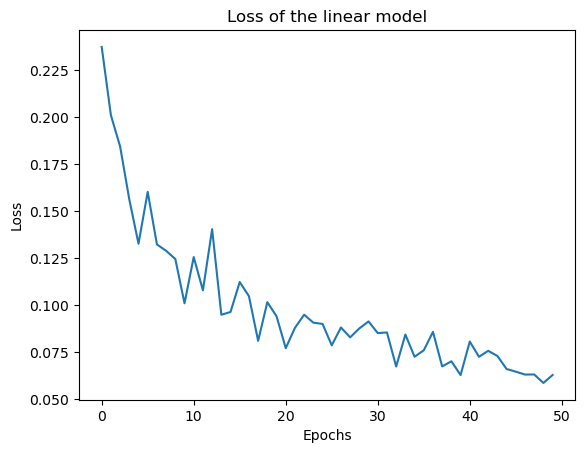

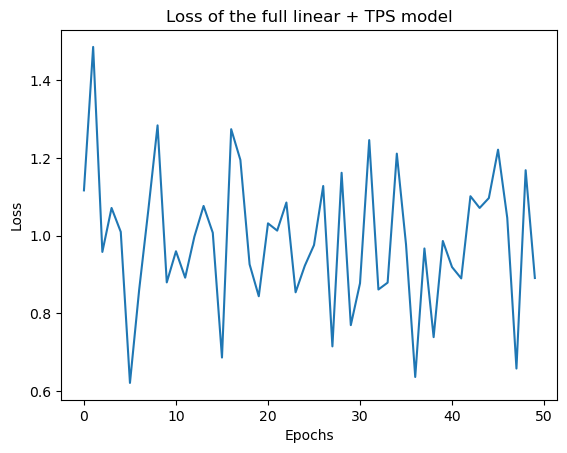

In [51]:
plt.figure()
plt.plot(loss_hist)
plt.title('Loss of the linear model')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(loss_hist_tps)
plt.title('Loss of the full linear + TPS model')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [30]:
# test the result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
affine_transformation_test = AffineTransformationTest(feature_extractor, correlation_layer, regression_network, affine_transform)
# test_gen = 
I_a, I_b, __ = next(data_gen)
I_a_test = I_a.to(device)
I_b_test = I_b.to(device)
test_loss, output_im = affine_transformation_test(I_a_test, I_b_test)

tensor(0.0460, device='cuda:0')


Text(0.5, 1.0, 'I_a moved to I_b')

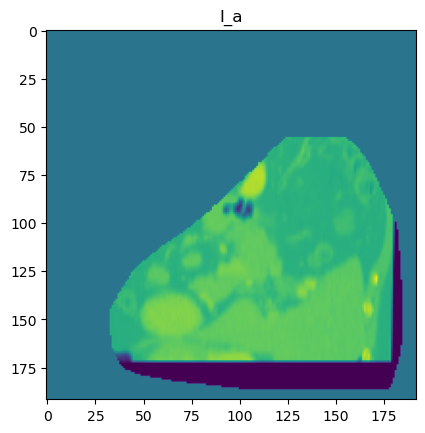

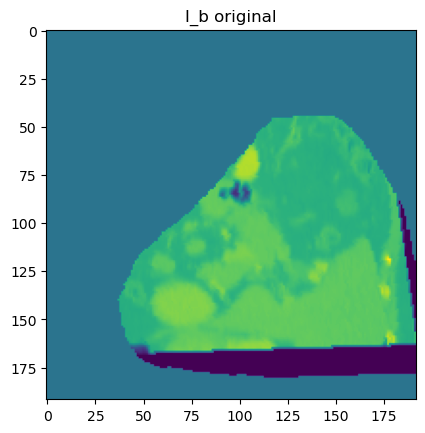

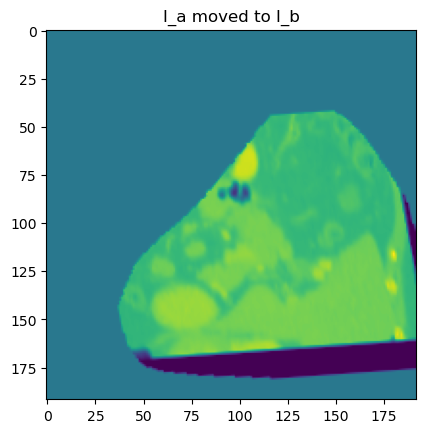

In [31]:
output_im = output_im.cpu()
I_a_trns_plot = output_im.detach().numpy()
print(test_loss)

plt.figure()
plt.imshow(I_a.squeeze())
plt.title('I_a')
plt.figure()
plt.imshow(I_b.squeeze())
plt.title('I_b original')
plt.figure()
plt.imshow(I_a_trns_plot.squeeze())
plt.title('I_a moved to I_b')

Text(0.5, 1.0, 'Seg_a moved to Seg_b')

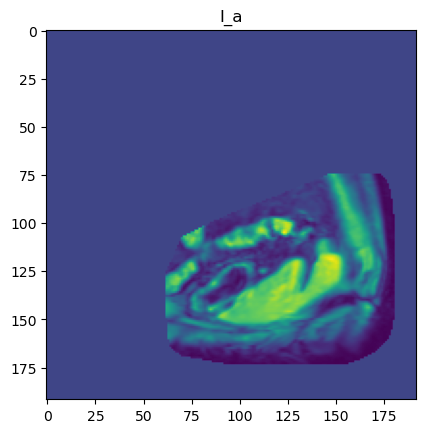

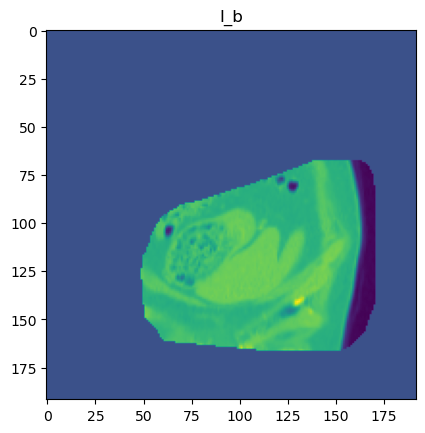

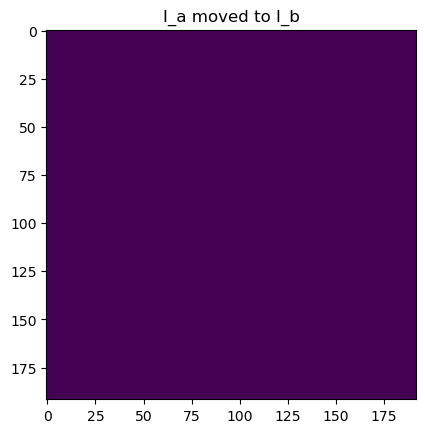

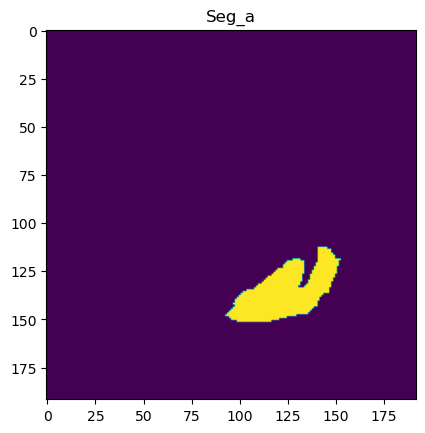

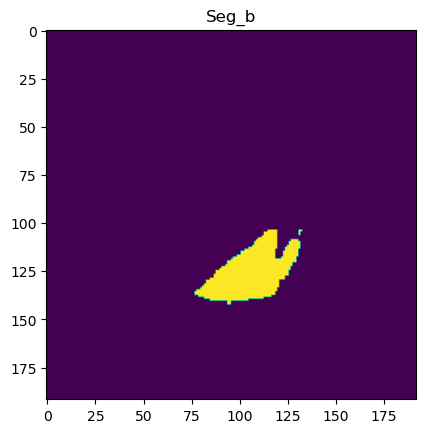

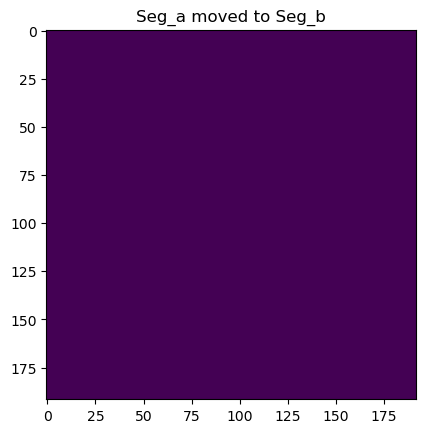

In [16]:
full_transformation_test = FullTransformationTest(affine_net_test, feature_extractor_tps, correlation_layer_tps,
                                                  regression_network_tps, tps_transform, loss_fn_tps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

I_a_full, I_b_full, seg_a_full, seg_b_full = next(data_gen_tps)
I_a_full_test = I_a_full.to(device)
I_b_full_test = I_b_full.to(device)
seg_a_full_test = seg_a_full.to(device)
seg_b_full_test = seg_b_full.to(device)
test_dice, transformed_I_a_full, transformed_seg_a_full = full_transformation_test.test_slice(I_a_full_test, I_b_full_test, seg_a_full_test, seg_b_full_test)

plt.figure()
plt.imshow(I_a_full.squeeze())
plt.title('MRI')
plt.figure()
plt.imshow(I_b_full.squeeze())
plt.title('CT')
plt.figure()
plt.imshow(transformed_I_a_full.squeeze())
plt.title('MRI moved to CT')


plt.figure()
plt.imshow(seg_a_full.squeeze())
plt.title('MRI Seg')
plt.figure()
plt.imshow(seg_b_full.squeeze())
plt.title('CT Seg')
plt.figure()
plt.imshow(transformed_seg_a_full.squeeze())
plt.title('MRI Seg moved to CT Seg')


In [3]:
# def extract_features_from_3d_volume(volume, model):
#     """
#     Function to extract features from each 2D slice of a 3D volume using a pre-trained 2D model.
    
#     Args:
#         volume: A 4D tensor of shape (H, D, W) representing the 3D volume (H = height, D = depth, W = width).
#         model: A pre-trained 2D model (e.g., ResNet18, modified to accept 1 channel).
    
#     Returns:
#         A 3D tensor of shape (feature_size, D), where feature_size is the size of the extracted features.
#     """
#     # Get the dimensions of the 3D volume
#     height, depth, width = volume.shape
    
#     # Prepare a list to store features from each slice
#     feature_list = []
    
#     # Iterate over the depth slices (each slice is a 2D image)
#     for i in range(depth):
#         slice_data = volume[:, i, :]  # Extract the i-th slice, shape (H, W)
        
#         # Add an extra channel dimension (1 channel) and make it (1, H, W)
#         slice_data = slice_data.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
        
#         # Move to GPU if available
#         slice_data = slice_data.cuda() if torch.cuda.is_available() else slice_data
        
#         # Pass the 2D slice through the model to extract features
#         with torch.no_grad():  # No need to compute gradients for feature extraction
#             features = model(slice_data)  # Shape: (1, feature_size)
        
#         # We only need the feature vector, remove the batch dimension (index 0)
#         features = features.squeeze(0)  # Shape: (feature_size,)
        
#         # Add the features to the feature list
#         feature_list.append(features.unsqueeze(1))  # Unsqueeze to keep it as a column (feature_size, 1)
    
#     # Stack the features for each slice along the depth dimension (combine all slices)
#     feature_map = torch.cat(feature_list, dim=1)  # Shape: (feature_size, depth)
    
#     feature_map = F.normalize(feature_map, p=2, dim=0)
    
#     return feature_map

# def correlationCalc(vol1, vol2):
#     """
#     Function to calculate correlation matrices for the outputs of feature extraction.
    
#     Args:
#         vol1: A 4D tensor of shape (Dimensions, Depth, Height, Width) representing the masks for the 3D volume.
#         vol2: A 4D tensor of shape (Dimensions, Depth, Height, Width) representing the masks for the 3D volume.
    
#     Returns:
#         A Correlation map of shape (Depth, Height, Width).
#     """

#     maskNum = vol1.shape[0]
#     depthNum = vol1.shape[1]
#     heightNum = vol1.shape[2]
#     widthNum = vol1.shape[3]
    
#     correlation_matrix = torch.zeros(depthNum, heightNum, widthNum)
    
#     for i in range(depthNum):
        
#         for j in range(heightNum):
            
#             for k in range(widthNum):
                
#                 dim1 = torch.squeeze(vol1[:, i, j, k])
#                 dim2 = torch.squeeze(vol2[:, i, j, k])
#                 correlation_matrix[i, j, k] = torch.dot(dim1, dim2)
                
#     # post processing
#     # apply ReLU:
#     correlation_matrix = torch.relu(correlation_matrix)
    
                
#     return correlation_matrix
                
    

# class affineReg(nn.Module):
#     def __init__(self):
#         super(affineReg, self).__init__()

#         # Define the layers
#         # Conv1: Input 1 channel (12x12), Output 128 channels
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, stride=1, padding=2)  # 5x5 kernel
#         self.bn1 = nn.BatchNorm2d(128)  # Batch normalization for the first convolution
#         self.relu1 = nn.ReLU(inplace=True)  # ReLU activation after batch normalization
        
#         # Conv2: Input 128 channels, Output 64 channels
#         self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)  # 3x3 kernel
#         self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for the second convolution
#         self.relu2 = nn.ReLU(inplace=True)  # ReLU activation after batch normalization
        
#         # Fully connected layer to output affine transformation parameters (6 values)
#         # Each slice will output 6 values, so we use a fully connected layer for each slice
#         self.fc = nn.Linear(64 * 12 * 12, 6)  # Each slice has size 12x12, with 64 channels after conv2

#     def forward(self, x):
#         # Apply first convolutional block
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
        
#         # Apply second convolutional block
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
        
#         # Flatten the result of the convolution (for each slice independently)
#         # Now x is of shape (batch_size, 64, 12, 12) for each slice, we flatten it to (batch_size, 64*12*12)
#         x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64 * 12 * 12)
        
#         # Apply fully connected layer for affine transformation parameters (6 values)
#         x = self.fc(x)  # Shape: (batch_size, 6)
        
#         # Reshape the output to have one output for each slice (160 slices)
#         x = x.view(160, 6)  # Shape: (batch_size, 160, 6)
        
#         return x


# def affineTransformer(image, theta, alpha=0.1, extrap='linear'):
#     affine_matrix = sitk.TranslationTransform(2)
#     # Matrix 1
#     a = 1 + alpha * theta[0]
#     b = alpha * theta[1]
#     c = alpha * theta[3]
#     d = 1 + alpha * theta[4]
    
#     # Matrix 2
#     e = alpha * theta[2]
#     f = alpha * theta[5]
    
#     # Define the matrix for the linear part (2x2)
#     matrix = [a, b, c, d]
#     affine_matrix.SetMatrix(matrix)

#     # Define the translation part (2x1)
#     translation = [e, f]
#     affine_matrix.SetTranslation(translation)
    
#     if extrap == 'linear':
#         resampled_image = sitk.Resample(image, image, affine_matrix, sitk.sitkLinear, 0.0)
        
#     elif extrap == 'nearest':
#         resampled_image = sitk.Resample(image, image, affine_matrix, sitk.sitkNearestNeighbor, 0.0)
        
#     return resampled_image


# def ncc_loss(fixed_image, moved_image):
#     """
#     Compute the Normalized Cross-Correlation (NCC) loss between the fixed and moved image.
    
#     Args:
#         fixed_image (torch.Tensor): The fixed image (H, W).
#         moved_image (torch.Tensor): The transformed moving image (H, W).
    
#     Returns:
#         torch.Tensor: The NCC loss (negative value since we want to maximize NCC).
#     """
#     # Compute the mean of each image
#     fixed_mean = fixed_image.mean()
#     moved_mean = moved_image.mean()
    
#     # Subtract the means
#     fixed_image = fixed_image - fixed_mean
#     moved_image = moved_image - moved_mean
    
#     # Compute the NCC numerator and denominator
#     numerator = (fixed_image * moved_image).sum()
#     denominator = torch.sqrt((fixed_image**2).sum() * (moved_image**2).sum())
    
#     # Return the negative NCC as the loss (to minimize)
#     return -numerator / denominator
    
    
    
# class AffineRegistrationModel(nn.Module):
#     def __init__(self, feature_extractor, affine_regressor):
#         """
#         Initializes the full model that combines feature extraction, correlation calculation, 
#         affine regression and transformation.
        
#         Args:
#             feature_extractor: Pre-trained model for feature extraction (e.g., ResNet).
#             affine_regressor: The network that regresses affine transformation parameters.
#         """
#         super(AffineRegistrationModel, self).__init__()
#         self.feature_extractor = feature_extractor  # ResNet or other model
#         self.affine_regressor = affine_regressor  # The affineReg model for parameter prediction
    
#     def forward(self, fixed_volume, moving_volume):
#         """
#         Forward pass of the model. 
#         It extracts features from the fixed and moving volumes, calculates correlation maps, 
#         predicts affine parameters, applies the affine transformation and computes the loss.
        
#         Args:
#             fixed_volume: The fixed 3D volume (batch_size, H, 160, W).
#             moving_volume: The moving 3D volume (batch_size, H, 160, W).
        
#         Returns:
#             loss: The NCC loss between the fixed and transformed moving image.
#             transformed_image: The transformed moving image after affine transformation.
#         """
#         # Step 1: Extract features from the 3D volumes
#         fixed_features = extract_features_from_3d_volume(fixed_volume, self.feature_extractor)
#         moving_features = extract_features_from_3d_volume(moving_volume, self.feature_extractor)
        
#         # Step 2: Calculate the correlation maps between the fixed and moving features
#         correlation_maps = correlationCalc(fixed_features, moving_features)  # Shape: (depth, height, width)
        
#         # Step 3: Use the affine regressor to get affine parameters (theta) for each slice
#         affine_params = self.affine_regressor(correlation_maps)  # Shape: (batch_size, 160, 6)
        
#         # Step 4: Apply affine transformation to each slice in the moving image
#         batch_size, depth, height, width = moving_volume.shape
#         transformed_image = torch.zeros_like(moving_volume).cuda()  # To hold the transformed image
        
#         # Loop through each slice (depth dimension) and apply the affine transformation
#         for i in range(depth):
#             # Extract the affine parameters for slice i (theta)
#             theta = affine_params[0, i, :].cpu().detach().numpy()  # Extract the 6 parameters for this slice
            
#             # Apply the affine transformation to the moving image (slice-wise)
#             transformed_image[0, i, :, :] = affineTransformer(moving_volume[0, i, :, :], theta).cpu()
        
#         # Step 5: Compute the NCC loss between the fixed and transformed moving image
#         loss = ncc_loss(fixed_volume, transformed_image)  # Calculate NCC loss
        
#         return loss, transformed_image

In [25]:

#     # Example 3D volume (batch_size, channels, depth, height, width)
# volume = torch.randn(192, 160, 192)  # 2 samples, 1 channel, 10 depth slices, 224x224 images

# # Extract features
# features = extract_features_from_3d_volume(volume, pretrained_model)

# # The output features will have shape (batch_size, feature_size, depth)
# print(features.shape)  # For example, (2, 512, 10), where 512 is the feature size of ResNet18


In [ ]:

# MRFolder = 'L2R_Task1_MR'
# CTFolder = 'L2R_Task1_CT'
# MRCT_trainFolder = 'L2R_Task1_MRCT_Train'
# MRCT_testFolder = 'L2R_Task1_MRCT_test'

# ############################### MR Folder #################################################################

# # The subfolder within the parent folder that has the same name
# MRsubfolder = os.path.join(MRFolder, os.path.basename(MRFolder))

# # Initialize lists to store the data
# MR_img_list = []
# MR_seg_list = []

# def extract_number_from_filename(filename):
#     # Assuming the format is 'img00XX' or 'seg00XX', the number is always at the last 4 digits
#     # Example: "img0001", "seg0040", etc.
#     return int(filename[3:7])

# # Traverse through the subfolder to find all .nii folders that contain .nii.gz files
# for root, dirs, files in os.walk(MRsubfolder):
#     # We want to look for folders that contain .nii.gz files
#     for file in files:
#         # Check if the file ends with .nii.gz
#         if file.endswith('.nii.gz'):
#             # Get the full file path
#             file_path = os.path.join(root, file)

#             # Check if the file name starts with "img" or "seg"
#             if file.startswith('img'):
#                 # Read the .nii.gz file using SimpleITK
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'img' files
#                 MR_img_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to train data list (img group).")
            
#             elif file.startswith('seg'):
#                 # Read the .nii.gz file using SimpleITK
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'seg' files
#                 MR_seg_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to segmentation data list (seg group).")

# # Sort the lists by the extracted numeric value
# MR_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
# MR_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)

# # Now extract the actual data arrays (second element of the tuple)
# MRTrainImg = np.stack([x[1] for x in MR_img_list], axis=0)
# MRTrainSeg = np.stack([x[1] for x in MR_seg_list], axis=0)

# ######################################### CT Folder #######################################################
# # The subfolder within the parent folder that has the same name
# CTsubfolder = os.path.join(CTFolder, os.path.basename(CTFolder))

# # Initialize lists to store the data
# CT_img_list = []
# CT_seg_list = []

# # Traverse through the subfolder to find all .nii folders that contain .nii.gz files
# for root, dirs, files in os.walk(CTsubfolder):
#     # We want to look for folders that contain .nii.gz files
#     for file in files:
#         # Check if the file ends with .nii.gz
#         if file.endswith('.nii.gz'):
#             # Get the full file path
#             file_path = os.path.join(root, file)

#             # Check if the file name starts with "img" or "seg"
#             if file.startswith('img'):
#                 # Read the .nii.gz file using SimpleITK
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'img' files
#                 CT_img_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to train data list (img group).")
                
#                 # print(file)
            
#             elif file.startswith('seg'):
#                 # Read the .nii.gz file using SimpleITK
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'seg' files
#                 CT_seg_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to segmentation data list (seg group).")

# # Sort the lists by the extracted numeric value
# CT_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
# CT_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)

# # Now extract the actual data arrays (second element of the tuple)
# CTTrainImg = np.stack([x[1] for x in CT_img_list], axis=0)
# CTTrainSeg = np.stack([x[1] for x in CT_seg_list], axis=0)                

# # # Stack the lists into a single numpy array
# # CTTrainImg = np.stack(MR_img_list, axis=0)
# # CTTrainSeg = np.stack(MR_seg_list, axis=0)


# ################################################ CT and MR Mixed Train ##################################################

# PairedTrainFolder = os.path.join(MRCT_trainFolder, 'Train')

# # Initialize lists to store the data
# pairedMR_img_list = []
# pairedMR_seg_list = []
# pairedCT_img_list = []
# pairedCT_seg_list = []

# # Traverse through the subfolder to find all .nii folders that contain .nii.gz files
# for root, dirs, files in os.walk(PairedTrainFolder):
    
#     dirs[:] = [d for d in dirs if not d.startswith('.')]
    
#     # We want to look for folders that contain .nii.gz files
#     for file in files:
#         # Check if the file ends with .nii.gz
#         if file.endswith('CT.nii.gz'):
#             # Get the full file path
#             file_path = os.path.join(root, file)

#             # Check if the file name starts with "img" or "seg"
#             if file.startswith('img'):
#                 # Read the .nii.gz file using SimpleITK
                
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'img' files
#                 pairedCT_img_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to train data list (img group).")
            
#             elif file.startswith('seg'):
#                 # Read the .nii.gz file using SimpleITK
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'seg' files
#                 pairedCT_seg_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to segmentation data list (seg group).")
#         elif file.endswith('MR.nii.gz'):
#             # Get the full file path
#             file_path = os.path.join(root, file)

#             # Check if the file name starts with "img" or "seg"
#             if file.startswith('img'):
#                 # Read the .nii.gz file using SimpleITK
                
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'img' files
#                 pairedMR_img_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to train data list (img group).")
            
#             elif file.startswith('seg'):
#                 # Read the .nii.gz file using SimpleITK
#                 img = sitk.ReadImage(file_path)
                
#                 # Convert the SimpleITK image to a numpy array
#                 img_data_array = sitk.GetArrayFromImage(img)
                
#                 # Append the numpy array to the list for 'seg' files
#                 pairedMR_seg_list.append((extract_number_from_filename(file), img_data_array))
#                 # print(f"Added {file} to segmentation data list (seg group).")

                
# # Sort the lists by the extracted numeric value
# pairedCT_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
# pairedCT_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
# pairedMR_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
# pairedMR_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)

# # Now extract the actual data arrays (second element of the tuple)
# CTPairedTrainImg = np.stack([x[1] for x in pairedCT_img_list], axis=0)
# CTPairedTrainSeg = np.stack([x[1] for x in pairedCT_seg_list], axis=0)   
# MRPairedTrainImg = np.stack([x[1] for x in pairedMR_img_list], axis=0)
# MRPairedTrainSeg = np.stack([x[1] for x in pairedMR_seg_list], axis=0)

In [ ]:
# # Initialize the pre-trained ResNet model for feature extraction (assume it's modified to accept grayscale)
# resnet_model = pretrained_resnet18()  # Pre-trained model, assuming it's modified
# affine_regressor_model = affineReg()  # The affine regressor network

# # Create the full model
# model = AffineRegistrationModel(resnet_model, affine_regressor_model)

# # Move the model to GPU if available
# model = model.cuda() if torch.cuda.is_available() else model

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# for epoch in range(100):  # Number of epochs
#     model.train()
    
#     # Example batch of fixed and moving images (assuming (batch_size, 160, H, W) shape)
#     fixed_image = torch.randn(1, 160, 12, 12).cuda()  # Example fixed image (batch_size=1, 160 slices)
#     moving_image = torch.randn(1, 160, 12, 12).cuda()  # Example moving image
    
#     # Zero gradients
#     optimizer.zero_grad()
    
#     # Forward pass through the model
#     loss, transformed_image = model(fixed_image, moving_image)
    
#     # Backpropagation
#     loss.backward()
    
#     # Update model parameters
#     optimizer.step()
    
#     # Print loss for this epoch
#     print(f"Epoch {epoch}, Loss: {loss.item()}")